In [14]:
import warnings                                  # do not disturbe mode
warnings.filterwarnings('ignore')

# Load packages
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

# Importing everything from forecasting quality metrics
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

In [15]:
def optimizeSARIMA(y, parameters_list, d, D, s):
    """Return dataframe with parameters and corresponding AIC
        
        y - time series
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(y, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [16]:
def plotSARIMA(series, model, n_steps, Item, Index):
    """Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future    
    """
    
    # adding model values
    dict_test = {}
    data = series.copy()
    data.columns = ['DateID','DailySales']
    data['sarima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['sarima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    print(forecast.values)
    w1 = np.sum(forecast.values[0:7])
    w2 = np.sum(forecast.values[7:14])
    w3 = np.sum(forecast.values[14:21])
    w4 = np.sum(forecast.values[21:28])
    forecast = data.sarima_model.append(forecast)
    
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['DailySales'][s+d:], data['sarima_model'][s+d:])
    dict_test[index] = [Item, w1, w2, w3, w4, error]
    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.DailySales, label="actual")
    plt.legend()
    plt.grid(True)
    
    return dict_test

In [17]:
# MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [18]:
train_path = '../input/data-storm-30/train_data.csv'
train_dataset = pd.read_csv(train_path)
train_dataset = train_dataset.drop_duplicates(keep = 'first')

cat_1_train_dataset = train_dataset.loc[train_dataset['CategoryCode'] == 'category_1']
cat_2_train_dataset = train_dataset.loc[train_dataset['CategoryCode'] == 'category_2']
cat_3_train_dataset = train_dataset.loc[train_dataset['CategoryCode'] == 'category_3']
cat_4_train_dataset = train_dataset.loc[train_dataset['CategoryCode'] == 'category_4']

cat_1_train_dataset["DateID"] = pd.to_datetime(cat_1_train_dataset["DateID"])
cat_1_train_dataset.sort_values(by='DateID', inplace=True)

cat_1_timeseries = cat_1_train_dataset.groupby('DateID')['DailySales'].sum()

cat_2_train_dataset["DateID"] = pd.to_datetime(cat_2_train_dataset["DateID"])
cat_2_train_dataset.sort_values(by='DateID', inplace=True)

cat_3_train_dataset["DateID"] = pd.to_datetime(cat_3_train_dataset["DateID"])
cat_3_train_dataset.sort_values(by='DateID', inplace=True)

cat_4_train_dataset["DateID"] = pd.to_datetime(cat_4_train_dataset["DateID"])
cat_4_train_dataset.sort_values(by='DateID', inplace=True)

In [ ]:
train_dataset["DateID"] = pd.to_datetime(train_dataset["DateID"])
train_dataset.sort_values(by='DateID', inplace=True)

In [ ]:
Item_3148_train_dataset = train_dataset.loc[train_dataset['ItemCode'] == 23200]
print(Item_3148_train_dataset)
Item_3148_train_dataset_forTraining = Item_3148_train_dataset[['DateID', 'DailySales']]
Item_3148_train_dataset_forTraining.head()

In [ ]:
print(len(Item_3148_train_dataset_forTraining))

In [ ]:
Item_3148_train_dataset_forTraining.plot(x='DateID',y='DailySales', grid = True, figsize = (20,8))

In [ ]:
Item_3148_train_dataset_forTraining.index = range(79)

In [ ]:
Item_3148_series = Item_3148_train_dataset_forTraining["DailySales"].squeeze()
Item_3148_series

In [ ]:
tsplot(Item_3148_train_dataset_forTraining["DailySales"], lags=14)

In [19]:
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 14 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [ ]:
warnings.filterwarnings("ignore") 
result_table = optimizeSARIMA(Item_3148_series, parameters_list, d, D, s)

In [ ]:
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(Item_3148_series, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

tsplot(best_model.resid[60+1:], lags=8)

In [ ]:
plotSARIMA(Item_3148_train_dataset_forTraining, best_model, 28)

In [20]:
list_test = [9925,16936, 23200, 32245, 35449, 35530, 36898, 37510 , 37861, 38518, 39436,41830, 42424,42496, 43630, 43738, 43738, 57058, 65788, 86992, 87046, 87559, 88450, 111382,111436,117610,119554,123307,130993,132334,145330,145978,169504,174436,213802,216151,225259,262384,267478,370195, 371104,687616,731104,753613,815101,837943,838456,839374,858886,872260,893824,903976,906595,999403,1003183,1003192,1006090,1006099,1021264,1024810,1032532,1032559,1032568,1044610,1044691,1047967,1049776,1054978,1056463,1060630,1061341,1063600,1067074,1067119,1067128,1068883,1070818,1071115,1075651,1076929,1077118,1081060,1081069,1081078,1081321,1081339,1082743,1085749,1090024,1090258,1092184,1101553,1101562,1101571,1101769,1103056,1105018,1105027]

print(len(list_test))

list_new = [9925,16936]

98


In [ ]:
dict = {}
keys = range(len(list_test))


9925



  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                   96
Model:             SARIMAX(3, 1, 2)x(0, 1, [1], 14)   Log Likelihood                -182.722
Date:                              Mon, 28 Mar 2022   AIC                            379.443
Time:                                      10:13:06   BIC                            396.204
Sample:                                           0   HQIC                           386.168
                                               - 96                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6621      0.324      2.041      0.041       0.026       1.298
ar.L2          0.02

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  111
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 14)   Log Likelihood                -408.102
Date:                              Mon, 28 Mar 2022   AIC                            828.204
Time:                                      10:14:49   BIC                            843.590
Sample:                                           0   HQIC                           834.423
                                              - 111                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9161      1.454     -0.630      0.529      -3.766       1.934
ar.L2          0.00

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                   79
Model:             SARIMAX(3, 1, 3)x(0, 1, [1], 14)   Log Likelihood                -241.016
Date:                              Mon, 28 Mar 2022   AIC                            498.032
Time:                                      10:16:07   BIC                            515.303
Sample:                                           0   HQIC                           504.836
                                               - 79                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9087      0.198      4.586      0.000       0.520       1.297
ar.L2         -0.85

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  128
Model:             SARIMAX(2, 1, 3)x(0, 1, [1], 14)   Log Likelihood                -388.283
Date:                              Mon, 28 Mar 2022   AIC                            790.567
Time:                                      10:17:52   BIC                            809.658
Sample:                                           0   HQIC                           798.314
                                              - 128                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4860      0.107    -13.854      0.000      -1.696      -1.276
ar.L2         -0.94

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                   79
Model:             SARIMAX(2, 1, 3)x(0, 1, [1], 14)   Log Likelihood                -174.492
Date:                              Mon, 28 Mar 2022   AIC                            362.984
Time:                                      10:19:08   BIC                            378.096
Sample:                                           0   HQIC                           368.938
                                               - 79                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7758      0.158     -4.921      0.000      -1.085      -0.467
ar.L2         -0.88

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                   74
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 14)   Log Likelihood                -170.571
Date:                              Mon, 28 Mar 2022   AIC                            353.142
Time:                                      10:20:20   BIC                            365.607
Sample:                                           0   HQIC                           358.008
                                               - 74                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0569      1.418     -0.040      0.968      -2.836       2.722
ar.L2          0.19

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  135
Model:             SARIMAX(3, 1, 4)x(0, 1, [1], 14)   Log Likelihood                -410.548
Date:                              Mon, 28 Mar 2022   AIC                            839.095
Time:                                      10:22:03   BIC                            864.182
Sample:                                           0   HQIC                           849.283
                                              - 135                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6245      0.148     -4.222      0.000      -0.914      -0.335
ar.L2          0.29

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                   74
Model:             SARIMAX(3, 1, 2)x(0, 1, [1], 14)   Log Likelihood                -125.244
Date:                              Mon, 28 Mar 2022   AIC                            264.487
Time:                                      10:23:14   BIC                            279.030
Sample:                                           0   HQIC                           270.164
                                               - 74                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6553      0.209      3.130      0.002       0.245       1.066
ar.L2         -0.11

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  135
Model:             SARIMAX(2, 1, 4)x(0, 1, [1], 14)   Log Likelihood                -509.163
Date:                              Mon, 28 Mar 2022   AIC                           1034.325
Time:                                      10:24:59   BIC                           1056.625
Sample:                                           0   HQIC                          1043.381
                                              - 135                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5140      0.111      4.643      0.000       0.297       0.731
ar.L2         -0.97

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  109
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 14)   Log Likelihood                -236.908
Date:                              Mon, 28 Mar 2022   AIC                            485.816
Time:                                      10:26:35   BIC                            501.075
Sample:                                           0   HQIC                           491.979
                                              - 109                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9264      0.166     -5.579      0.000      -1.252      -0.601
ar.L2          0.07

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  115
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 14)   Log Likelihood                -380.014
Date:                              Mon, 28 Mar 2022   AIC                            772.027
Time:                                      10:28:09   BIC                            787.658
Sample:                                           0   HQIC                           778.353
                                              - 115                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0772      0.506     -0.153      0.879      -1.068       0.914
ar.L2          0.31

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  118
Model:             SARIMAX(4, 1, 2)x(0, 1, [1], 14)   Log Likelihood                -210.890
Date:                              Mon, 28 Mar 2022   AIC                            437.780
Time:                                      10:29:47   BIC                            458.858
Sample:                                           0   HQIC                           446.318
                                              - 118                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7244      0.134     -5.408      0.000      -0.987      -0.462
ar.L2          0.28

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  128
Model:             SARIMAX(2, 1, 3)x(1, 1, [1], 14)   Log Likelihood                -333.661
Date:                              Mon, 28 Mar 2022   AIC                            683.322
Time:                                      10:31:32   BIC                            705.141
Sample:                                           0   HQIC                           692.176
                                              - 128                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0449      0.152      0.295      0.768      -0.253       0.343
ar.L2          0.90

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  123
Model:             SARIMAX(3, 1, 3)x(0, 1, [1], 14)   Log Likelihood                -342.031
Date:                              Mon, 28 Mar 2022   AIC                            700.061
Time:                                      10:33:16   BIC                            721.518
Sample:                                           0   HQIC                           708.761
                                              - 123                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5493      0.137     -4.019      0.000      -0.817      -0.281
ar.L2         -0.69

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  131
Model:             SARIMAX(2, 1, 3)x(0, 1, [1], 14)   Log Likelihood                -299.235
Date:                              Mon, 28 Mar 2022   AIC                            612.469
Time:                                      10:35:00   BIC                            631.744
Sample:                                           0   HQIC                           620.294
                                              - 131                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6107      0.081      7.567      0.000       0.453       0.769
ar.L2         -0.78

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  109
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 14)   Log Likelihood                -231.790
Date:                              Mon, 28 Mar 2022   AIC                            475.579
Time:                                      10:36:36   BIC                            490.839
Sample:                                           0   HQIC                           481.743
                                              - 109                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8768      0.177     -4.947      0.000      -1.224      -0.529
ar.L2          0.03

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  109
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 14)   Log Likelihood                -231.790
Date:                              Mon, 28 Mar 2022   AIC                            475.579
Time:                                      10:38:11   BIC                            490.839
Sample:                                           0   HQIC                           481.743
                                              - 109                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8768      0.177     -4.947      0.000      -1.224      -0.529
ar.L2          0.03

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                      
Dep. Variable:                          DailySales   No. Observations:                   68
Model:             SARIMAX(2, 1, 3)x(1, 1, [], 14)   Log Likelihood                -123.814
Date:                             Mon, 28 Mar 2022   AIC                            261.628
Time:                                     10:39:10   BIC                            275.420
Sample:                                          0   HQIC                           266.932
                                              - 68                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5892      0.180     -8.848      0.000      -1.941      -1.237
ar.L2         -0.6760      

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  109
Model:             SARIMAX(4, 1, 3)x(0, 1, [1], 14)   Log Likelihood                -206.820
Date:                              Mon, 28 Mar 2022   AIC                            431.640
Time:                                      10:40:37   BIC                            454.530
Sample:                                           0   HQIC                           440.886
                                              - 109                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9554      0.225      4.248      0.000       0.515       1.396
ar.L2         -0.71

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  135
Model:             SARIMAX(2, 1, 4)x(0, 1, [1], 14)   Log Likelihood                -384.120
Date:                              Mon, 28 Mar 2022   AIC                            784.240
Time:                                      10:42:10   BIC                            806.540
Sample:                                           0   HQIC                           793.296
                                              - 135                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1366      0.242     -0.564      0.573      -0.611       0.338
ar.L2         -0.40

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                      
Dep. Variable:                          DailySales   No. Observations:                   71
Model:             SARIMAX(4, 1, 2)x(1, 1, [], 14)   Log Likelihood                 -97.939
Date:                             Mon, 28 Mar 2022   AIC                            211.878
Time:                                     10:43:20   BIC                            228.081
Sample:                                          0   HQIC                           218.160
                                              - 71                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2915      0.152      1.918      0.055      -0.006       0.589
ar.L2         -0.5387      

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  127
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 14)   Log Likelihood                -333.037
Date:                              Mon, 28 Mar 2022   AIC                            678.073
Time:                                      10:45:06   BIC                            694.384
Sample:                                           0   HQIC                           684.691
                                              - 127                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0800      0.263     -4.114      0.000      -1.595      -0.565
ar.L2         -0.14

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  131
Model:             SARIMAX(2, 1, 3)x(0, 1, [1], 14)   Log Likelihood                -465.696
Date:                              Mon, 28 Mar 2022   AIC                            945.392
Time:                                      10:46:53   BIC                            964.667
Sample:                                           0   HQIC                           953.217
                                              - 131                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2219      0.234     -0.949      0.342      -0.680       0.236
ar.L2         -0.78

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  107
Model:             SARIMAX(2, 1, 3)x(0, 1, [1], 14)   Log Likelihood                -193.430
Date:                              Mon, 28 Mar 2022   AIC                            400.861
Time:                                      10:48:28   BIC                            418.513
Sample:                                           0   HQIC                           407.985
                                              - 107                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.9101      0.085    -22.434      0.000      -2.077      -1.743
ar.L2         -0.94

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                      
Dep. Variable:                          DailySales   No. Observations:                   81
Model:             SARIMAX(4, 1, 2)x(0, 1, [], 14)   Log Likelihood                -135.728
Date:                             Mon, 28 Mar 2022   AIC                            285.456
Time:                                     10:49:38   BIC                            300.783
Sample:                                          0   HQIC                           291.512
                                              - 81                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0036      0.177      0.020      0.984      -0.344       0.351
ar.L2         -0.6861      

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  100
Model:             SARIMAX(4, 1, 2)x(0, 1, [1], 14)   Log Likelihood                -238.394
Date:                              Mon, 28 Mar 2022   AIC                            492.787
Time:                                      10:51:08   BIC                            512.328
Sample:                                           0   HQIC                           500.647
                                              - 100                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8447      0.122      6.908      0.000       0.605       1.084
ar.L2          0.09

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  136
Model:             SARIMAX(2, 1, 3)x(0, 1, [1], 14)   Log Likelihood                -521.762
Date:                              Mon, 28 Mar 2022   AIC                           1057.524
Time:                                      10:53:00   BIC                           1077.094
Sample:                                           0   HQIC                          1065.472
                                              - 136                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7482      0.052    -14.446      0.000      -0.850      -0.647
ar.L2         -0.95

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  132
Model:             SARIMAX(3, 1, 3)x(0, 1, [1], 14)   Log Likelihood                -590.197
Date:                              Mon, 28 Mar 2022   AIC                           1196.394
Time:                                      10:54:46   BIC                           1218.492
Sample:                                           0   HQIC                          1205.366
                                              - 132                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4679      0.102    -14.419      0.000      -1.667      -1.268
ar.L2         -0.74

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                   96
Model:             SARIMAX(2, 1, 3)x(0, 1, [1], 14)   Log Likelihood                -236.836
Date:                              Mon, 28 Mar 2022   AIC                            487.673
Time:                                      10:56:08   BIC                            504.434
Sample:                                           0   HQIC                           494.398
                                               - 96                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4268      0.165     -8.626      0.000      -1.751      -1.103
ar.L2         -0.77

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  114
Model:             SARIMAX(3, 1, 4)x(1, 1, [1], 14)   Log Likelihood                -256.671
Date:                              Mon, 28 Mar 2022   AIC                            533.342
Time:                                      10:57:43   BIC                            559.293
Sample:                                           0   HQIC                           543.842
                                              - 114                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2410      0.617      0.391      0.696      -0.968       1.450
ar.L2         -0.44

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  108
Model:             SARIMAX(2, 1, 3)x(0, 1, [1], 14)   Log Likelihood                -205.203
Date:                              Mon, 28 Mar 2022   AIC                            424.406
Time:                                      10:59:17   BIC                            442.134
Sample:                                           0   HQIC                           431.564
                                              - 108                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7335      0.055    -13.400      0.000      -0.841      -0.626
ar.L2         -0.94

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  134
Model:             SARIMAX(2, 1, 3)x(0, 1, [1], 14)   Log Likelihood                -318.317
Date:                              Mon, 28 Mar 2022   AIC                            650.633
Time:                                      11:01:04   BIC                            670.087
Sample:                                           0   HQIC                           658.533
                                              - 134                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3979      0.070    -19.969      0.000      -1.535      -1.261
ar.L2         -0.85

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  135
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 14)   Log Likelihood                -633.757
Date:                              Mon, 28 Mar 2022   AIC                           1281.514
Time:                                      11:02:59   BIC                           1301.027
Sample:                                           0   HQIC                          1289.438
                                              - 135                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9585      0.145     -6.595      0.000      -1.243      -0.674
ar.L2         -0.07

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  135
Model:             SARIMAX(2, 1, 3)x(1, 1, [1], 14)   Log Likelihood                -348.475
Date:                              Mon, 28 Mar 2022   AIC                            712.950
Time:                                      11:04:45   BIC                            735.250
Sample:                                           0   HQIC                           722.006
                                              - 135                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8728      0.094    -19.905      0.000      -2.057      -1.688
ar.L2         -0.88

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                   91
Model:             SARIMAX(2, 1, 3)x(0, 1, [1], 14)   Log Likelihood                -122.567
Date:                              Mon, 28 Mar 2022   AIC                            259.133
Time:                                      11:06:13   BIC                            275.449
Sample:                                           0   HQIC                           265.654
                                               - 91                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1435      0.170     -0.843      0.399      -0.477       0.190
ar.L2         -0.86

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  121
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 14)   Log Likelihood                -206.870
Date:                              Mon, 28 Mar 2022   AIC                            425.739
Time:                                      11:07:56   BIC                            441.720
Sample:                                           0   HQIC                           432.216
                                              - 121                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1189      0.656     -0.181      0.856      -1.404       1.166
ar.L2         -0.13

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                   94
Model:             SARIMAX(2, 1, 3)x(0, 1, [1], 14)   Log Likelihood                -168.889
Date:                              Mon, 28 Mar 2022   AIC                            351.778
Time:                                      11:09:20   BIC                            368.364
Sample:                                           0   HQIC                           358.423
                                               - 94                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8792      0.118     -7.451      0.000      -1.111      -0.648
ar.L2         -0.69

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  109
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 14)   Log Likelihood                -191.430
Date:                              Mon, 28 Mar 2022   AIC                            396.860
Time:                                      11:10:55   BIC                            414.663
Sample:                                           0   HQIC                           404.051
                                              - 109                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5987      0.219      2.728      0.006       0.169       1.029
ar.L2         -0.32

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                   86
Model:             SARIMAX(3, 1, 2)x(0, 1, [1], 14)   Log Likelihood                -176.198
Date:                              Mon, 28 Mar 2022   AIC                            366.395
Time:                                      11:12:12   BIC                            382.234
Sample:                                           0   HQIC                           372.694
                                               - 86                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7055      0.153     -4.621      0.000      -1.005      -0.406
ar.L2          0.18

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  118
Model:             SARIMAX(4, 1, 2)x(0, 1, [1], 14)   Log Likelihood                -375.528
Date:                              Mon, 28 Mar 2022   AIC                            767.057
Time:                                      11:13:55   BIC                            788.135
Sample:                                           0   HQIC                           775.594
                                              - 118                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6744      0.280     -2.408      0.016      -1.223      -0.125
ar.L2         -0.03

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                   80
Model:             SARIMAX(2, 1, 3)x(0, 1, [1], 14)   Log Likelihood                -171.198
Date:                              Mon, 28 Mar 2022   AIC                            356.396
Time:                                      11:15:05   BIC                            371.616
Sample:                                           0   HQIC                           362.401
                                               - 80                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4936      0.259     -5.771      0.000      -2.001      -0.986
ar.L2         -0.95

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                   96
Model:             SARIMAX(3, 1, 3)x(0, 1, [1], 14)   Log Likelihood                -183.255
Date:                              Mon, 28 Mar 2022   AIC                            382.509
Time:                                      11:16:27   BIC                            401.665
Sample:                                           0   HQIC                           390.195
                                               - 96                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3882      0.188     -2.066      0.039      -0.756      -0.020
ar.L2         -0.95

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                   78
Model:             SARIMAX(2, 1, 3)x(0, 1, [1], 14)   Log Likelihood                -175.200
Date:                              Mon, 28 Mar 2022   AIC                            364.400
Time:                                      11:17:30   BIC                            379.402
Sample:                                           0   HQIC                           370.301
                                               - 78                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5435      0.209     -2.600      0.009      -0.953      -0.134
ar.L2         -0.69

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                   90
Model:             SARIMAX(2, 1, 3)x(0, 1, [1], 14)   Log Likelihood                -289.485
Date:                              Mon, 28 Mar 2022   AIC                            592.971
Time:                                      11:18:48   BIC                            609.193
Sample:                                           0   HQIC                           599.448
                                               - 90                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4378      0.187     -7.671      0.000      -1.805      -1.070
ar.L2         -0.80

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  130
Model:             SARIMAX(4, 1, 3)x(0, 1, [1], 14)   Log Likelihood                -299.683
Date:                              Mon, 28 Mar 2022   AIC                            617.366
Time:                                      11:20:39   BIC                            642.070
Sample:                                           0   HQIC                           627.393
                                              - 130                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4818      0.128    -11.620      0.000      -1.732      -1.232
ar.L2         -0.83

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  136
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 14)   Log Likelihood                -404.211
Date:                              Mon, 28 Mar 2022   AIC                            820.422
Time:                                      11:22:27   BIC                            837.197
Sample:                                           0   HQIC                           827.235
                                              - 136                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8277      0.197     -4.211      0.000      -1.213      -0.442
ar.L2          0.13

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  121
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 14)   Log Likelihood                -223.722
Date:                              Mon, 28 Mar 2022   AIC                            459.445
Time:                                      11:24:01   BIC                            475.426
Sample:                                           0   HQIC                           465.922
                                              - 121                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0521      0.166     -6.351      0.000      -1.377      -0.727
ar.L2         -0.20

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  109
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 14)   Log Likelihood                -342.220
Date:                              Mon, 28 Mar 2022   AIC                            696.439
Time:                                      11:25:29   BIC                            711.699
Sample:                                           0   HQIC                           702.603
                                              - 109                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0015      0.301     -3.324      0.001      -1.592      -0.411
ar.L2         -0.01

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                   85
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 14)   Log Likelihood                -151.945
Date:                              Mon, 28 Mar 2022   AIC                            317.890
Time:                                      11:26:49   BIC                            333.630
Sample:                                           0   HQIC                           324.142
                                               - 85                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8682      0.257     -3.377      0.001      -1.372      -0.364
ar.L2          0.13

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                   88
Model:             SARIMAX(2, 1, 3)x(0, 1, [1], 14)   Log Likelihood                -180.450
Date:                              Mon, 28 Mar 2022   AIC                            374.899
Time:                                      11:28:06   BIC                            390.933
Sample:                                           0   HQIC                           381.289
                                               - 88                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6967      0.168      4.159      0.000       0.368       1.025
ar.L2         -0.60

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                   91
Model:             SARIMAX(2, 1, 4)x(0, 1, [1], 14)   Log Likelihood                -271.256
Date:                              Mon, 28 Mar 2022   AIC                            558.511
Time:                                      11:29:27   BIC                            577.157
Sample:                                           0   HQIC                           565.963
                                               - 91                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4531      0.160      2.838      0.005       0.140       0.766
ar.L2         -0.69

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  104
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 14)   Log Likelihood                -243.158
Date:                              Mon, 28 Mar 2022   AIC                            500.316
Time:                                      11:30:56   BIC                            517.736
Sample:                                           0   HQIC                           507.337
                                              - 104                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7621      0.159     -4.781      0.000      -1.075      -0.450
ar.L2          0.13

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                   97
Model:             SARIMAX(2, 1, 3)x(0, 1, [1], 14)   Log Likelihood                -126.846
Date:                              Mon, 28 Mar 2022   AIC                            267.692
Time:                                      11:32:20   BIC                            284.539
Sample:                                           0   HQIC                           274.456
                                               - 97                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0872      0.074     14.747      0.000       0.943       1.232
ar.L2         -0.88

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  105
Model:             SARIMAX(2, 1, 4)x(1, 1, [1], 14)   Log Likelihood                -226.117
Date:                              Mon, 28 Mar 2022   AIC                            470.233
Time:                                      11:33:50   BIC                            492.731
Sample:                                           0   HQIC                           479.306
                                              - 105                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9691      0.142     -6.849      0.000      -1.246      -0.692
ar.L2         -0.96

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                   95
Model:             SARIMAX(2, 1, 3)x(0, 1, [1], 14)   Log Likelihood                -219.947
Date:                              Mon, 28 Mar 2022   AIC                            453.895
Time:                                      11:35:07   BIC                            470.569
Sample:                                           0   HQIC                           460.580
                                               - 95                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7595      0.172     -4.420      0.000      -1.096      -0.423
ar.L2         -0.75

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  101
Model:             SARIMAX(2, 1, 3)x(0, 1, [1], 14)   Log Likelihood                -254.733
Date:                              Mon, 28 Mar 2022   AIC                            523.466
Time:                                      11:36:29   BIC                            540.647
Sample:                                           0   HQIC                           530.381
                                              - 101                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4138      0.131    -10.807      0.000      -1.670      -1.157
ar.L2         -0.71

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  117
Model:             SARIMAX(2, 1, 4)x(0, 1, [1], 14)   Log Likelihood                -242.164
Date:                              Mon, 28 Mar 2022   AIC                            500.327
Time:                                      11:38:04   BIC                            521.327
Sample:                                           0   HQIC                           508.831
                                              - 117                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5528      0.124     12.505      0.000       1.309       1.796
ar.L2         -0.74

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                      
Dep. Variable:                          DailySales   No. Observations:                   67
Model:             SARIMAX(4, 1, 3)x(1, 1, [], 14)   Log Likelihood                -124.566
Date:                             Mon, 28 Mar 2022   AIC                            267.132
Time:                                     11:39:02   BIC                            284.693
Sample:                                          0   HQIC                           273.864
                                              - 67                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2981      0.378     -3.437      0.001      -2.038      -0.558
ar.L2         -0.4892      

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                   75
Model:             SARIMAX(2, 1, 4)x(0, 1, [1], 14)   Log Likelihood                -168.803
Date:                              Mon, 28 Mar 2022   AIC                            353.605
Time:                                      11:39:58   BIC                            370.360
Sample:                                           0   HQIC                           360.159
                                               - 75                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6302      0.332      1.900      0.057      -0.020       1.281
ar.L2         -0.32

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  108
Model:             SARIMAX(3, 1, 3)x(0, 1, [1], 14)   Log Likelihood                -339.369
Date:                              Mon, 28 Mar 2022   AIC                            694.738
Time:                                      11:41:24   BIC                            714.999
Sample:                                           0   HQIC                           702.919
                                              - 108                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2874      0.184      7.001      0.000       0.927       1.648
ar.L2         -0.86

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  135
Model:             SARIMAX(4, 1, 2)x(0, 1, [1], 14)   Log Likelihood                -503.331
Date:                              Mon, 28 Mar 2022   AIC                           1022.662
Time:                                      11:43:14   BIC                           1044.962
Sample:                                           0   HQIC                          1031.719
                                              - 135                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0470      0.456      0.103      0.918      -0.846       0.940
ar.L2         -0.02

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  115
Model:             SARIMAX(2, 1, 3)x(1, 1, [1], 14)   Log Likelihood                -231.425
Date:                              Mon, 28 Mar 2022   AIC                            478.850
Time:                                      11:44:42   BIC                            499.691
Sample:                                           0   HQIC                           487.285
                                              - 115                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2459      0.185     -1.328      0.184      -0.609       0.117
ar.L2         -0.58

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                   79
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 14)   Log Likelihood                -272.095
Date:                              Mon, 28 Mar 2022   AIC                            556.191
Time:                                      11:45:57   BIC                            569.144
Sample:                                           0   HQIC                           561.294
                                               - 79                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9950      3.115     -0.319      0.749      -7.101       5.111
ar.L2         -0.01

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                   97
Model:             SARIMAX(2, 1, 3)x(0, 1, [1], 14)   Log Likelihood                -158.626
Date:                              Mon, 28 Mar 2022   AIC                            331.253
Time:                                      11:47:19   BIC                            348.100
Sample:                                           0   HQIC                           338.017
                                               - 97                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0567      0.033     -1.694      0.090      -0.122       0.009
ar.L2         -0.99

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  105
Model:             SARIMAX(3, 1, 3)x(0, 1, [1], 14)   Log Likelihood                -217.958
Date:                              Mon, 28 Mar 2022   AIC                            451.916
Time:                                      11:48:53   BIC                            471.915
Sample:                                           0   HQIC                           459.981
                                              - 105                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5754      0.179      3.214      0.001       0.225       0.926
ar.L2         -0.77

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  136
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 14)   Log Likelihood                -529.418
Date:                              Mon, 28 Mar 2022   AIC                           1070.835
Time:                                      11:50:51   BIC                           1087.610
Sample:                                           0   HQIC                          1077.648
                                              - 136                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0268      0.346     -2.964      0.003      -1.706      -0.348
ar.L2         -0.04

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  116
Model:             SARIMAX(2, 1, 3)x(0, 1, [1], 14)   Log Likelihood                -266.480
Date:                              Mon, 28 Mar 2022   AIC                            546.960
Time:                                      11:52:29   BIC                            565.265
Sample:                                           0   HQIC                           554.370
                                              - 116                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0154      0.124     -8.156      0.000      -1.259      -0.771
ar.L2         -0.75

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  132
Model:             SARIMAX(2, 1, 3)x(0, 1, [1], 14)   Log Likelihood                -363.303
Date:                              Mon, 28 Mar 2022   AIC                            740.606
Time:                                      11:54:20   BIC                            759.941
Sample:                                           0   HQIC                           748.456
                                              - 132                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1110      0.044     25.415      0.000       1.025       1.197
ar.L2         -0.99

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                      
Dep. Variable:                          DailySales   No. Observations:                  130
Model:             SARIMAX(2, 1, 4)x(1, 1, [], 14)   Log Likelihood                -453.175
Date:                             Mon, 28 Mar 2022   AIC                            922.350
Time:                                     11:56:03   BIC                            944.310
Sample:                                          0   HQIC                           931.264
                                             - 130                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2519      0.157     -1.601      0.109      -0.560       0.057
ar.L2         -0.8023      

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  126
Model:             SARIMAX(3, 1, 3)x(0, 1, [1], 14)   Log Likelihood                -288.093
Date:                              Mon, 28 Mar 2022   AIC                            592.187
Time:                                      11:57:37   BIC                            613.863
Sample:                                           0   HQIC                           600.980
                                              - 126                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3493      0.144     -9.366      0.000      -1.632      -1.067
ar.L2         -1.05

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  104
Model:             SARIMAX(2, 1, 3)x(1, 1, [1], 14)   Log Likelihood                -303.951
Date:                              Mon, 28 Mar 2022   AIC                            623.903
Time:                                      11:59:14   BIC                            643.812
Sample:                                           0   HQIC                           631.928
                                              - 104                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3002      0.155     -8.392      0.000      -1.604      -0.997
ar.L2         -0.88

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                   93
Model:             SARIMAX(3, 1, 3)x(1, 1, [1], 14)   Log Likelihood                -148.927
Date:                              Mon, 28 Mar 2022   AIC                            315.853
Time:                                      12:00:39   BIC                            337.064
Sample:                                           0   HQIC                           324.344
                                               - 93                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4852      0.142     -3.413      0.001      -0.764      -0.207
ar.L2         -0.90

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  115
Model:             SARIMAX(2, 1, 3)x(0, 1, [1], 14)   Log Likelihood                -351.139
Date:                              Mon, 28 Mar 2022   AIC                            716.278
Time:                                      12:02:21   BIC                            734.514
Sample:                                           0   HQIC                           723.659
                                              - 115                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4431      0.222     -2.000      0.045      -0.877      -0.009
ar.L2         -0.81

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  125
Model:             SARIMAX(3, 1, 3)x(0, 1, [1], 14)   Log Likelihood                -296.066
Date:                              Mon, 28 Mar 2022   AIC                            608.131
Time:                                      12:04:07   BIC                            629.735
Sample:                                           0   HQIC                           616.894
                                              - 125                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2269      0.122      1.857      0.063      -0.013       0.466
ar.L2         -0.97

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                   86
Model:             SARIMAX(3, 1, 2)x(0, 1, [1], 14)   Log Likelihood                -152.531
Date:                              Mon, 28 Mar 2022   AIC                            319.063
Time:                                      12:05:18   BIC                            334.901
Sample:                                           0   HQIC                           325.361
                                               - 86                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3697      0.178     -2.082      0.037      -0.718      -0.022
ar.L2         -0.62

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                   62
Model:             SARIMAX(2, 1, 4)x(0, 1, [1], 14)   Log Likelihood                 -70.464
Date:                              Mon, 28 Mar 2022   AIC                            156.927
Time:                                      12:06:24   BIC                            171.729
Sample:                                           0   HQIC                           162.497
                                               - 62                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1134      0.182      6.103      0.000       0.756       1.471
ar.L2         -0.81

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                   85
Model:             SARIMAX(2, 1, 3)x(0, 1, [1], 14)   Log Likelihood                -155.083
Date:                              Mon, 28 Mar 2022   AIC                            324.167
Time:                                      12:07:40   BIC                            339.906
Sample:                                           0   HQIC                           330.419
                                               - 85                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8452      0.146     -5.802      0.000      -1.131      -0.560
ar.L2         -0.91

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                   72
Model:             SARIMAX(2, 1, 3)x(0, 1, [1], 14)   Log Likelihood                -131.424
Date:                              Mon, 28 Mar 2022   AIC                            276.848
Time:                                      12:08:45   BIC                            291.149
Sample:                                           0   HQIC                           282.406
                                               - 72                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3074      0.212     -1.449      0.147      -0.723       0.108
ar.L2         -0.72

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                   73
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 14)   Log Likelihood                -132.349
Date:                              Mon, 28 Mar 2022   AIC                            276.699
Time:                                      12:09:52   BIC                            289.062
Sample:                                           0   HQIC                           281.514
                                               - 73                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0114      1.227     -0.824      0.410      -3.417       1.394
ar.L2         -0.10

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                      
Dep. Variable:                          DailySales   No. Observations:                   64
Model:             SARIMAX(2, 1, 2)x(0, 1, [], 14)   Log Likelihood                -145.634
Date:                             Mon, 28 Mar 2022   AIC                            301.267
Time:                                     12:10:59   BIC                            310.726
Sample:                                          0   HQIC                           304.856
                                              - 64                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3559      0.135     -2.636      0.008      -0.621      -0.091
ar.L2         -0.7452      

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                   66
Model:             SARIMAX(3, 1, 2)x(0, 1, [1], 14)   Log Likelihood                -141.145
Date:                              Mon, 28 Mar 2022   AIC                            296.289
Time:                                      12:11:59   BIC                            309.812
Sample:                                           0   HQIC                           301.457
                                               - 66                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2184      0.479      0.456      0.648      -0.720       1.157
ar.L2         -0.13

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  110
Model:             SARIMAX(2, 1, 3)x(1, 1, [1], 14)   Log Likelihood                -345.868
Date:                              Mon, 28 Mar 2022   AIC                            707.736
Time:                                      12:13:35   BIC                            728.167
Sample:                                           0   HQIC                           715.992
                                              - 110                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1037      0.186      0.558      0.577      -0.260       0.468
ar.L2          0.89

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                   82
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 14)   Log Likelihood                -172.672
Date:                              Mon, 28 Mar 2022   AIC                            359.344
Time:                                      12:14:51   BIC                            374.776
Sample:                                           0   HQIC                           365.450
                                               - 82                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1538      0.414     -0.372      0.710      -0.965       0.657
ar.L2         -0.30

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                   96
Model:             SARIMAX(2, 1, 3)x(0, 1, [1], 14)   Log Likelihood                -180.037
Date:                              Mon, 28 Mar 2022   AIC                            374.074
Time:                                      12:16:16   BIC                            390.835
Sample:                                           0   HQIC                           380.799
                                               - 96                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6835      0.252     -2.710      0.007      -1.178      -0.189
ar.L2         -0.78

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                   93
Model:             SARIMAX(2, 1, 3)x(0, 1, [1], 14)   Log Likelihood                -178.067
Date:                              Mon, 28 Mar 2022   AIC                            370.134
Time:                                      12:17:42   BIC                            386.631
Sample:                                           0   HQIC                           376.738
                                               - 93                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1461      0.038     -3.832      0.000      -0.221      -0.071
ar.L2         -0.99

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                   72
Model:             SARIMAX(2, 1, 3)x(0, 1, [1], 14)   Log Likelihood                -145.584
Date:                              Mon, 28 Mar 2022   AIC                            305.167
Time:                                      12:18:46   BIC                            319.468
Sample:                                           0   HQIC                           310.725
                                               - 72                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7437      0.221     -3.360      0.001      -1.177      -0.310
ar.L2         -0.76

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                   71
Model:             SARIMAX(2, 1, 3)x(0, 1, [1], 14)   Log Likelihood                -190.083
Date:                              Mon, 28 Mar 2022   AIC                            394.165
Time:                                      12:19:50   BIC                            408.343
Sample:                                           0   HQIC                           399.662
                                               - 71                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5801      0.047    -33.924      0.000      -1.671      -1.489
ar.L2         -0.99

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                   84
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 14)   Log Likelihood                -157.788
Date:                              Mon, 28 Mar 2022   AIC                            327.577
Time:                                      12:21:11   BIC                            340.982
Sample:                                           0   HQIC                           332.895
                                               - 84                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2877      0.816     -0.353      0.724      -1.886       1.311
ar.L2         -0.15

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  115
Model:             SARIMAX(4, 1, 3)x(0, 1, [1], 14)   Log Likelihood                -242.786
Date:                              Mon, 28 Mar 2022   AIC                            503.572
Time:                                      12:22:24   BIC                            527.019
Sample:                                           0   HQIC                           513.061
                                              - 115                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2367      0.232     -1.018      0.309      -0.692       0.219
ar.L2         -0.55

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                   75
Model:             SARIMAX(4, 1, 2)x(0, 1, [1], 14)   Log Likelihood                -222.254
Date:                              Mon, 28 Mar 2022   AIC                            460.507
Time:                                      12:23:35   BIC                            477.262
Sample:                                           0   HQIC                           467.061
                                               - 75                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7324      0.698     -1.049      0.294      -2.101       0.636
ar.L2          0.06

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  115
Model:             SARIMAX(4, 1, 3)x(0, 1, [1], 14)   Log Likelihood                -224.377
Date:                              Mon, 28 Mar 2022   AIC                            466.753
Time:                                      12:25:07   BIC                            490.200
Sample:                                           0   HQIC                           476.242
                                              - 115                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4464      0.157     -2.843      0.004      -0.754      -0.139
ar.L2         -0.71

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                   75
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 14)   Log Likelihood                -102.944
Date:                              Mon, 28 Mar 2022   AIC                            219.887
Time:                                      12:26:22   BIC                            234.548
Sample:                                           0   HQIC                           225.622
                                               - 75                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5300      0.847      0.626      0.531      -1.130       2.190
ar.L2          0.16

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                   94
Model:             SARIMAX(2, 1, 3)x(0, 1, [1], 14)   Log Likelihood                -152.385
Date:                              Mon, 28 Mar 2022   AIC                            318.770
Time:                                      12:27:45   BIC                            335.357
Sample:                                           0   HQIC                           325.415
                                               - 94                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1741      0.114     -1.525      0.127      -0.398       0.050
ar.L2         -0.90

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                   80
Model:             SARIMAX(2, 1, 4)x(0, 1, [1], 14)   Log Likelihood                -210.833
Date:                              Mon, 28 Mar 2022   AIC                            437.667
Time:                                      12:29:03   BIC                            455.062
Sample:                                           0   HQIC                           444.530
                                               - 80                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2401      0.184     -6.744      0.000      -1.601      -0.880
ar.L2         -0.99

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                   76
Model:             SARIMAX(2, 1, 3)x(0, 1, [1], 14)   Log Likelihood                -140.187
Date:                              Mon, 28 Mar 2022   AIC                            294.375
Time:                                      12:30:11   BIC                            309.151
Sample:                                           0   HQIC                           300.166
                                               - 76                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1961      0.190     -6.281      0.000      -1.569      -0.823
ar.L2         -0.43

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                  104
Model:             SARIMAX(2, 1, 3)x(0, 1, [1], 14)   Log Likelihood                -191.962
Date:                              Mon, 28 Mar 2022   AIC                            397.925
Time:                                      12:31:38   BIC                            415.345
Sample:                                           0   HQIC                           404.946
                                              - 104                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5470      0.071    -21.863      0.000      -1.686      -1.408
ar.L2         -0.91

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                   66
Model:             SARIMAX(2, 1, 3)x(0, 1, [1], 14)   Log Likelihood                 -87.918
Date:                              Mon, 28 Mar 2022   AIC                            189.835
Time:                                      12:32:45   BIC                            203.358
Sample:                                           0   HQIC                           195.003
                                               - 66                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6953      0.036    -47.337      0.000      -1.766      -1.625
ar.L2         -0.99

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                           DailySales   No. Observations:                   78
Model:             SARIMAX(2, 1, 4)x(0, 1, [1], 14)   Log Likelihood                -107.969
Date:                              Mon, 28 Mar 2022   AIC                            231.939
Time:                                      12:33:58   BIC                            249.084
Sample:                                           0   HQIC                           238.682
                                               - 78                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5430      0.162      3.356      0.001       0.226       0.860
ar.L2         -0.74

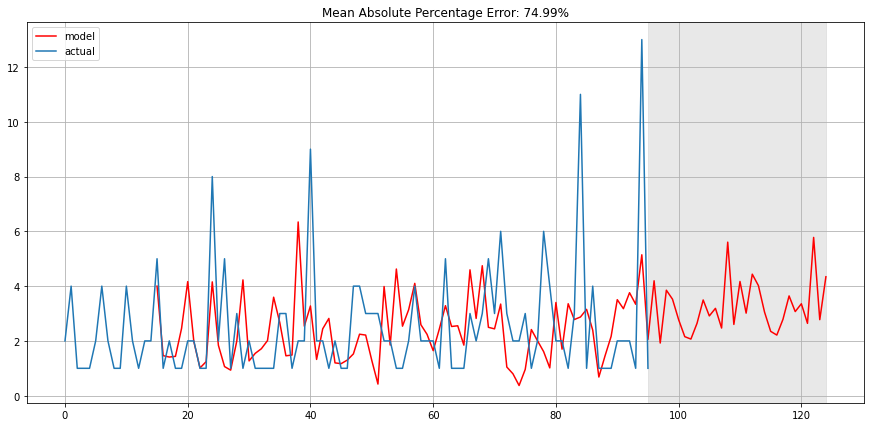

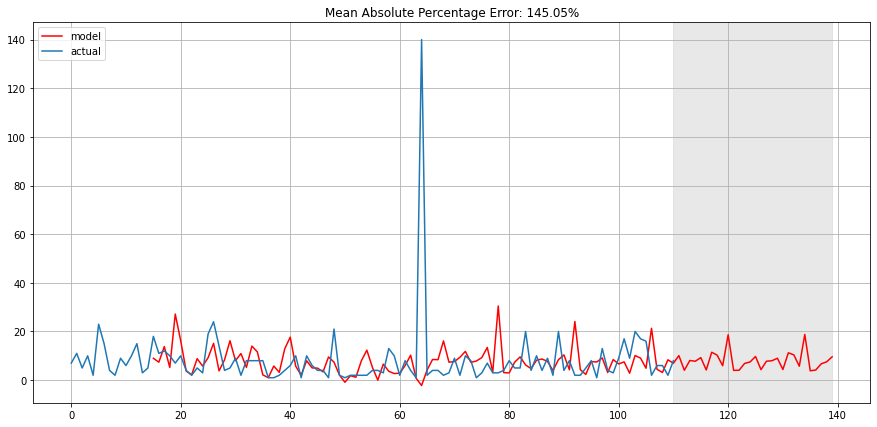

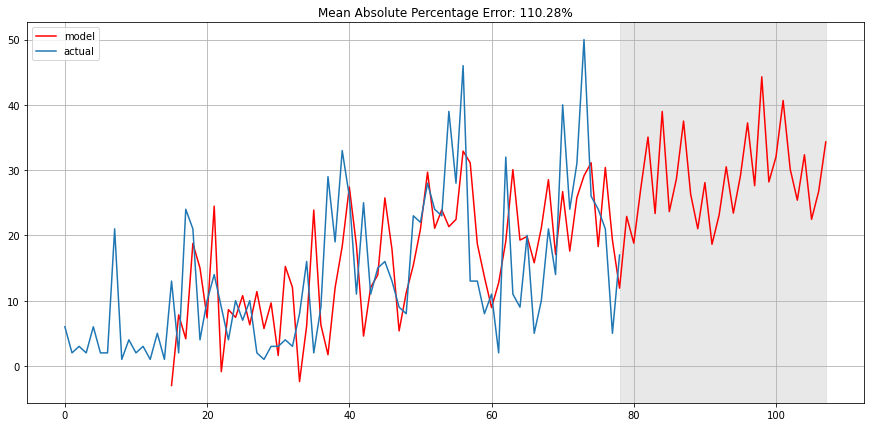

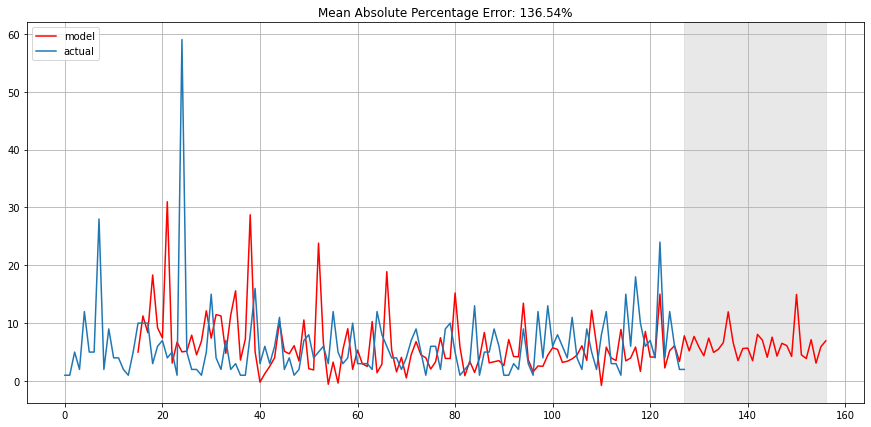

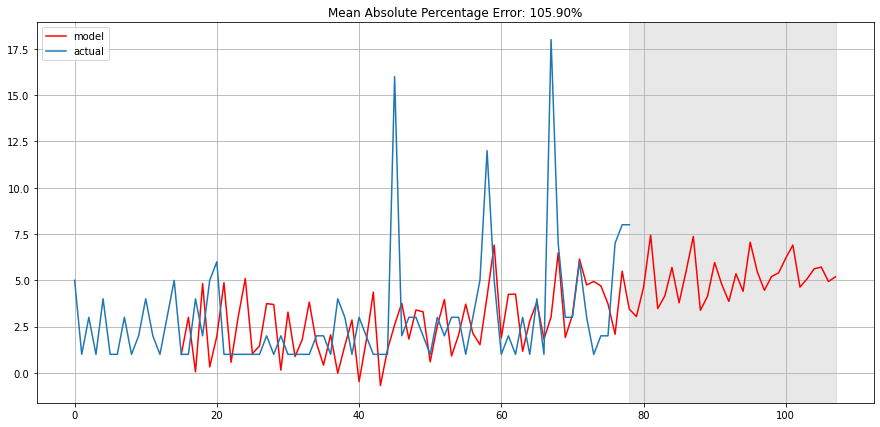

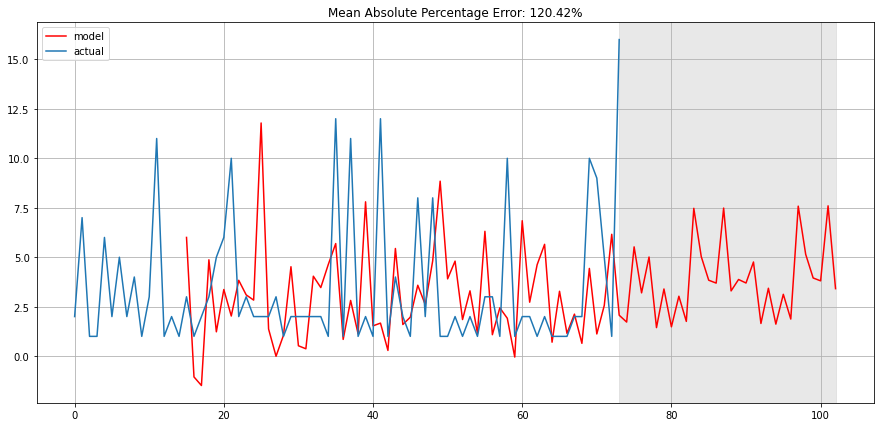

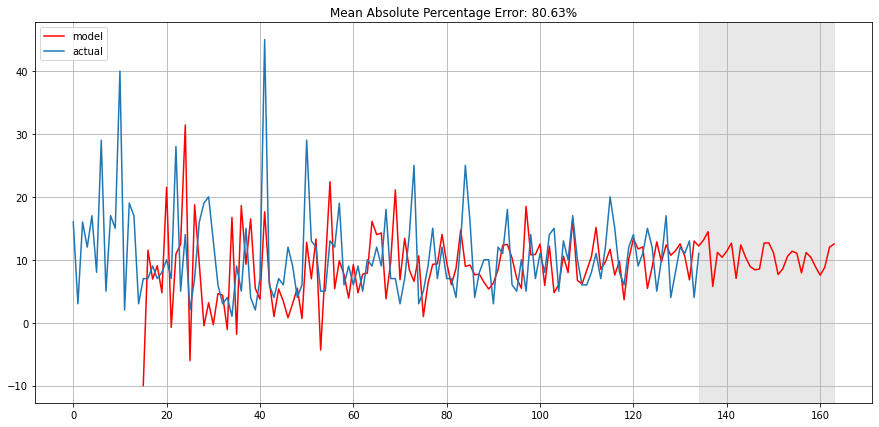

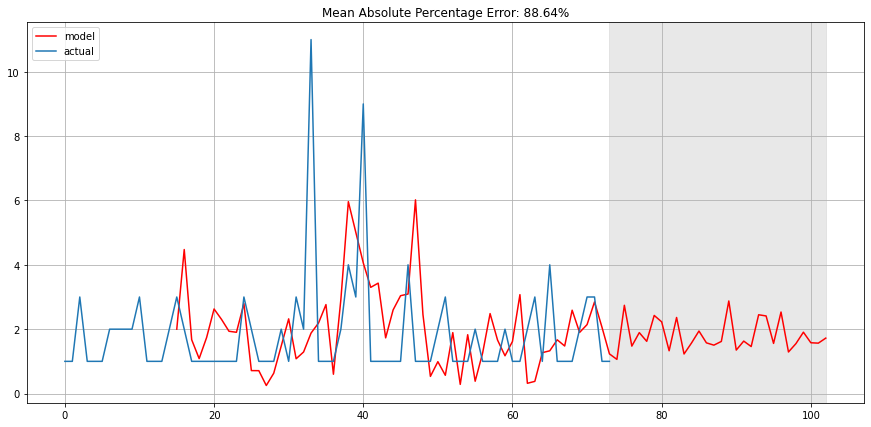

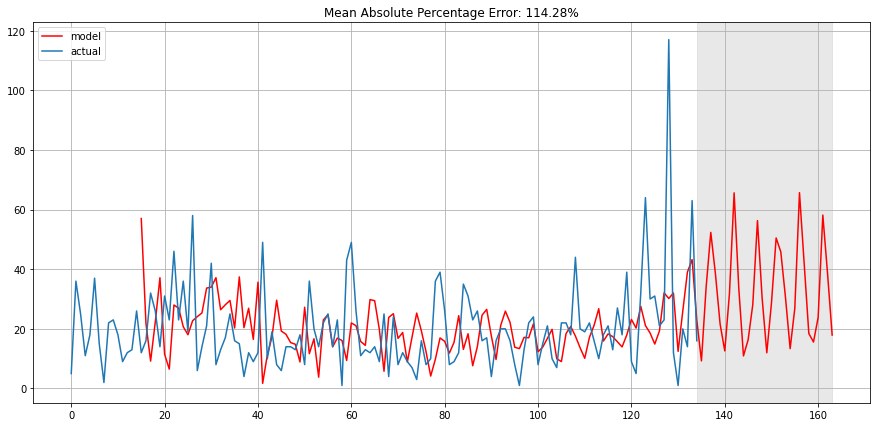

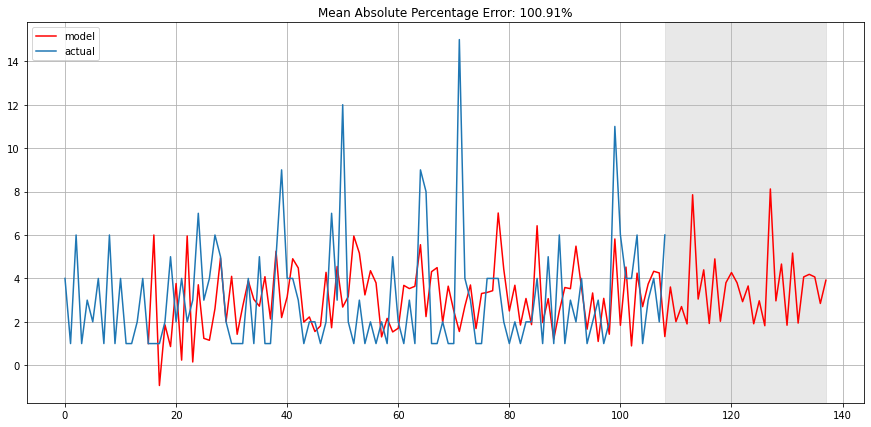

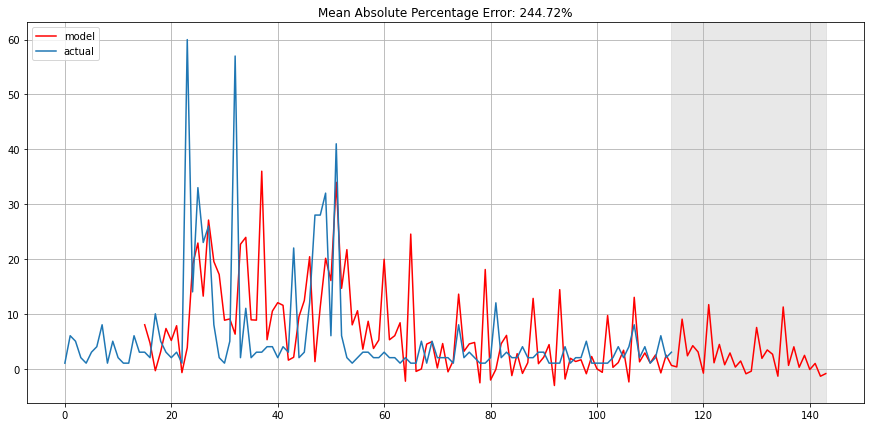

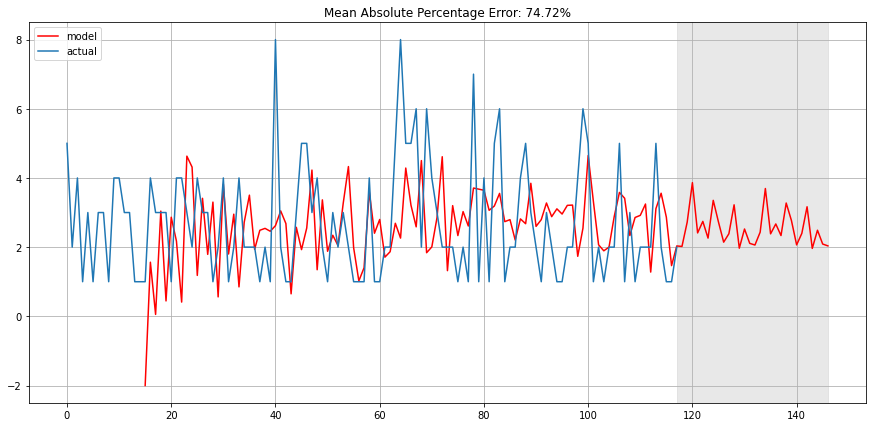

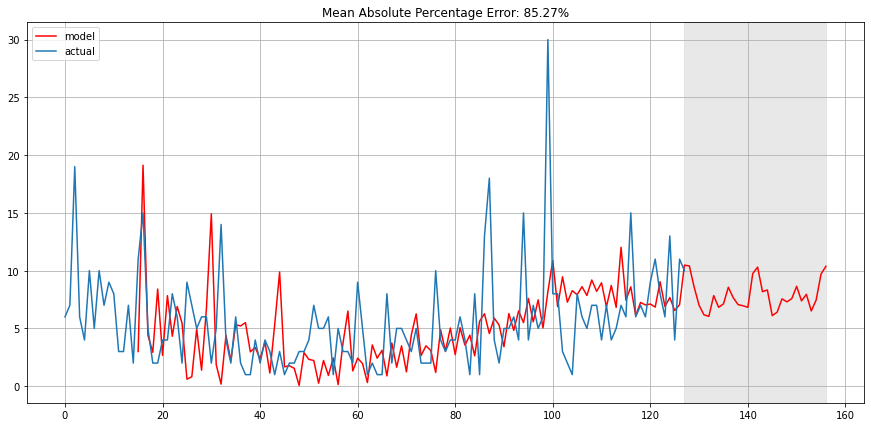

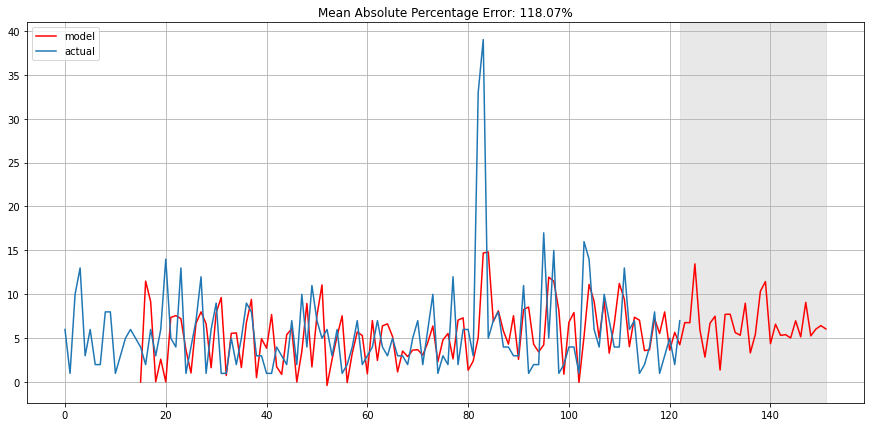

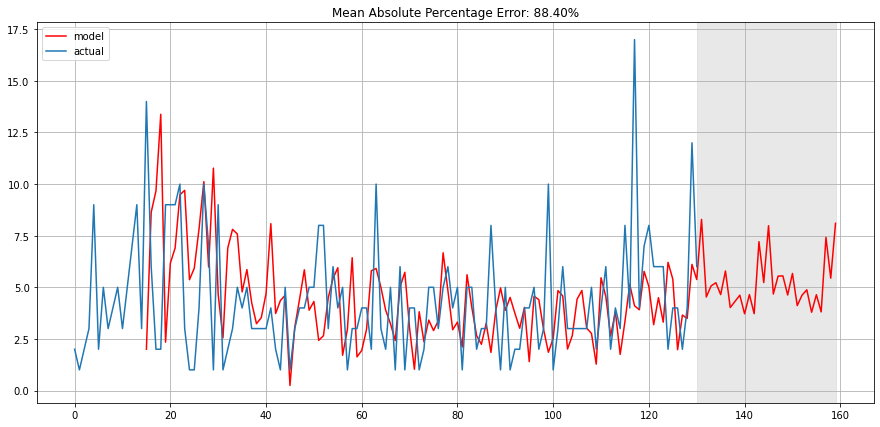

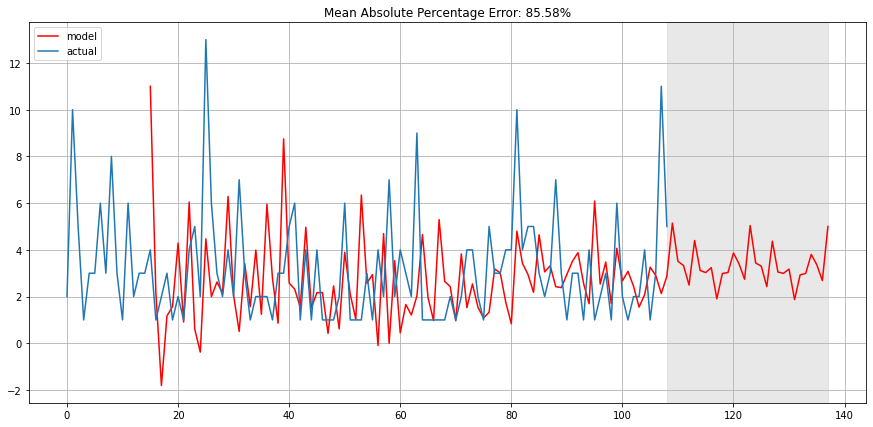

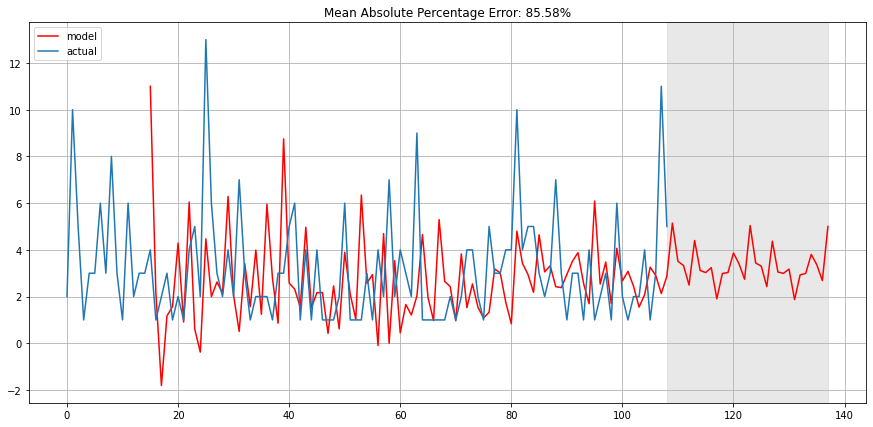

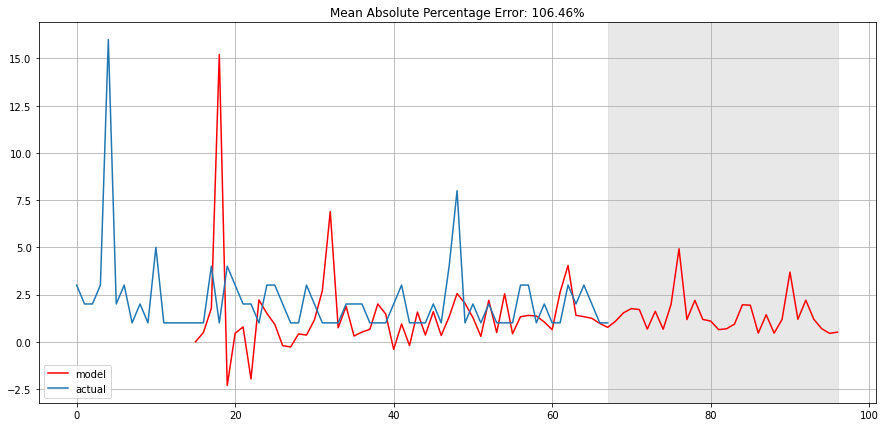

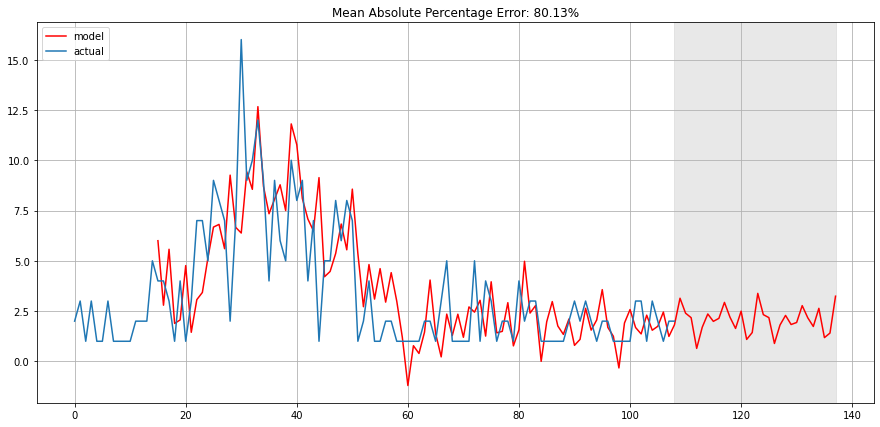

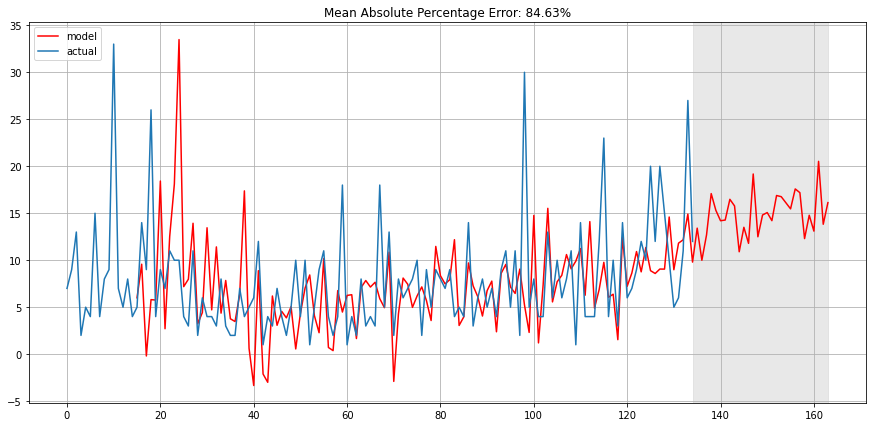

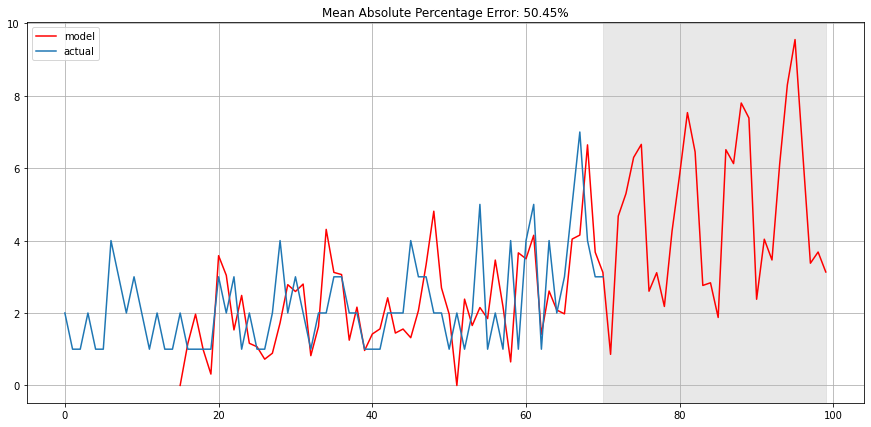

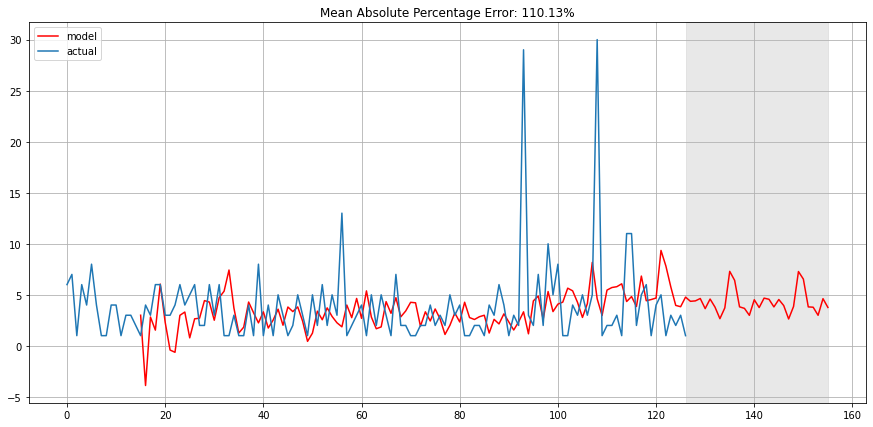

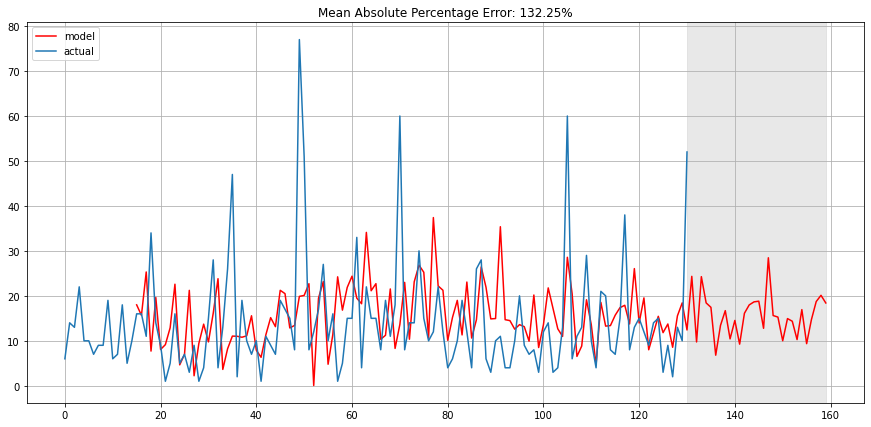

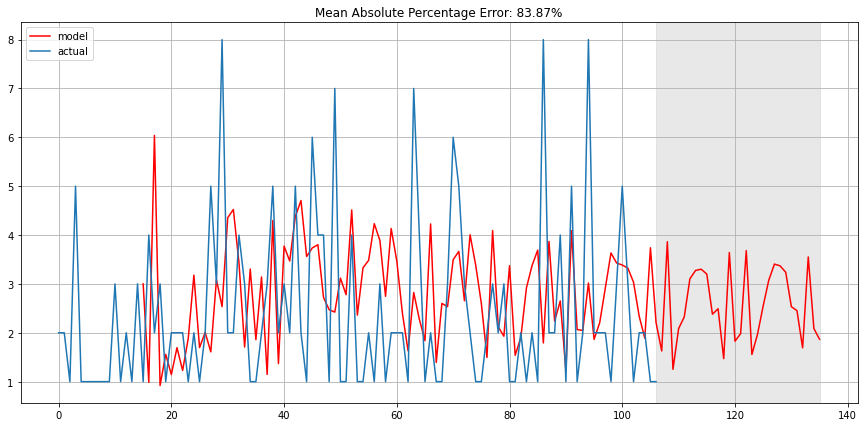

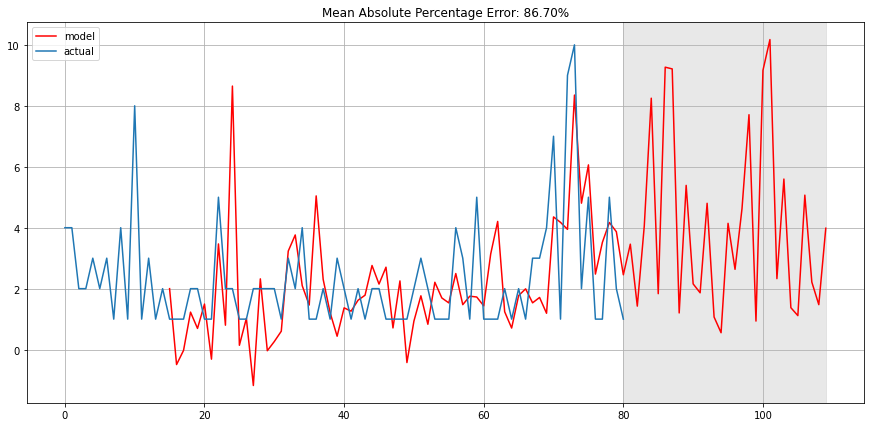

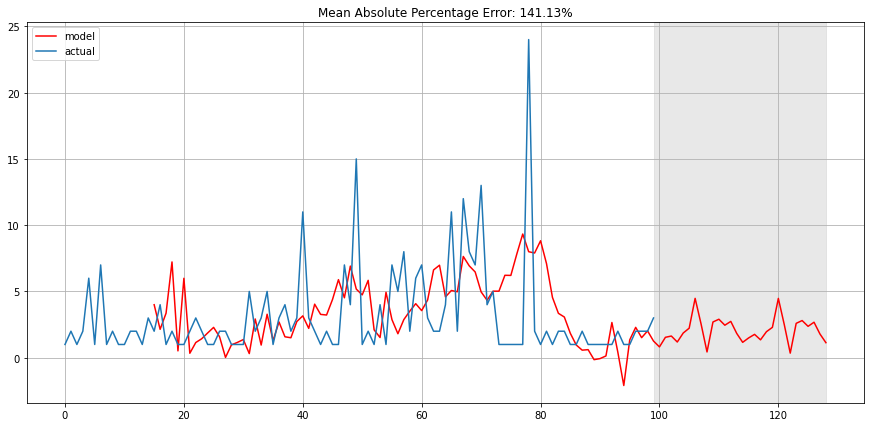

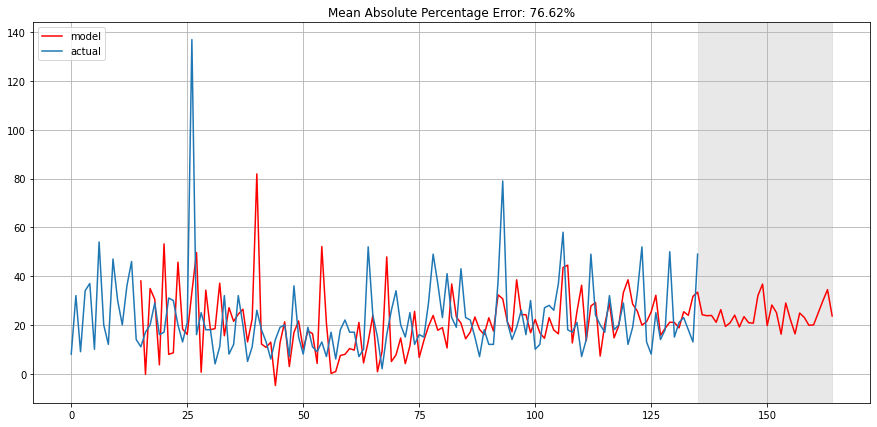

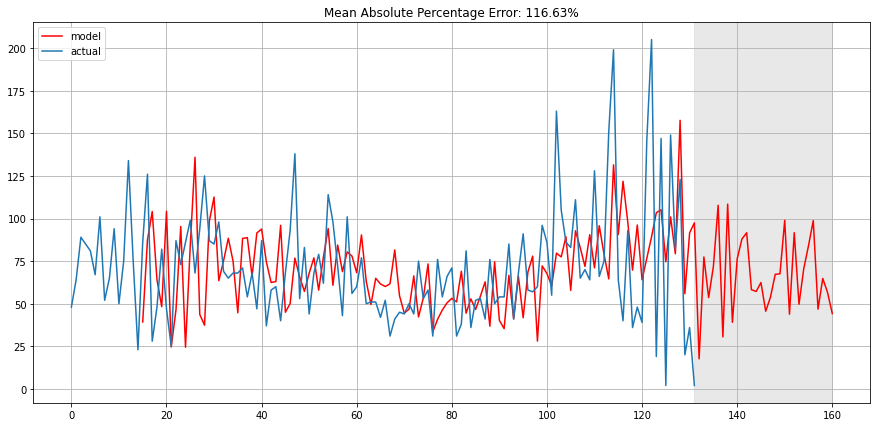

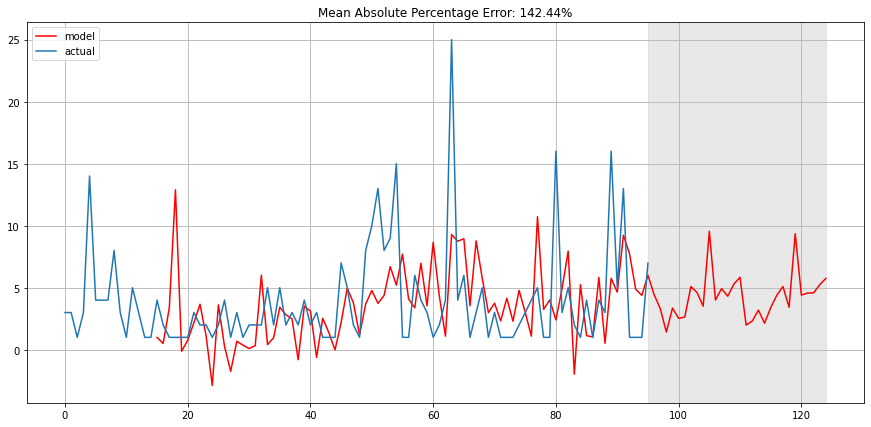

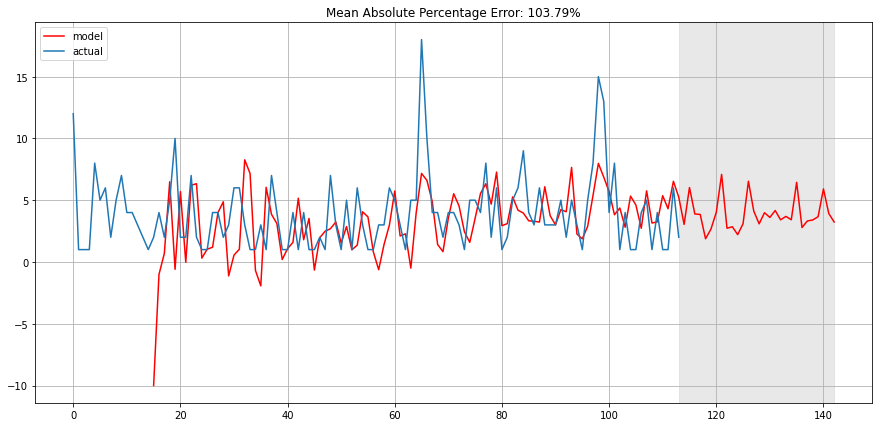

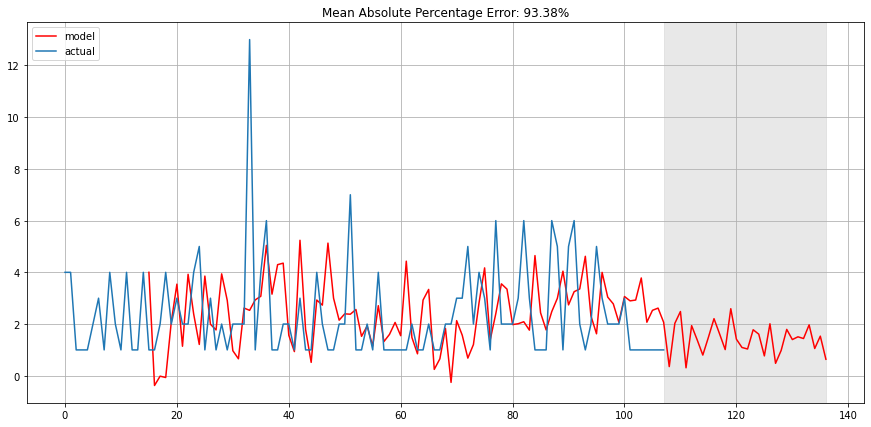

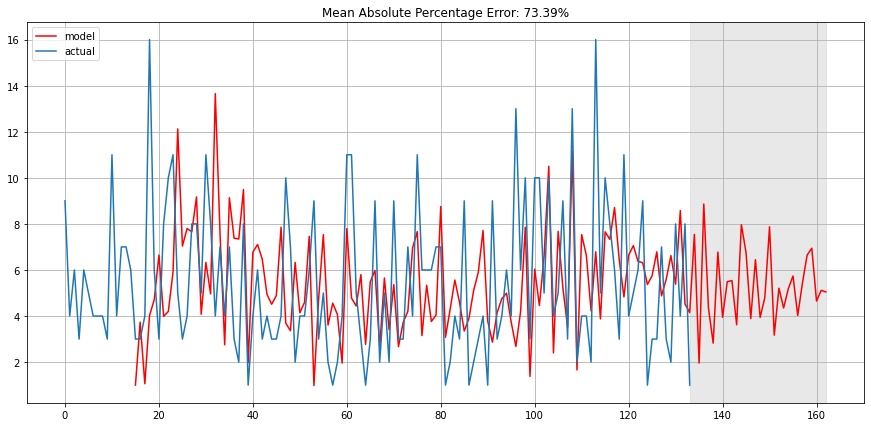

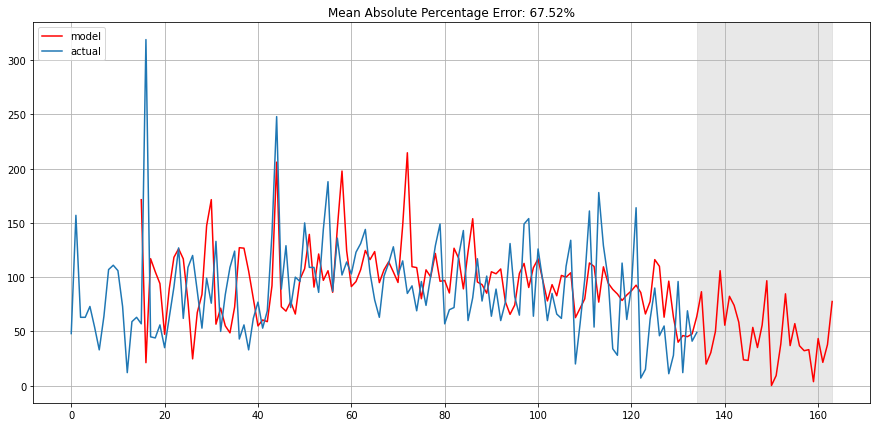

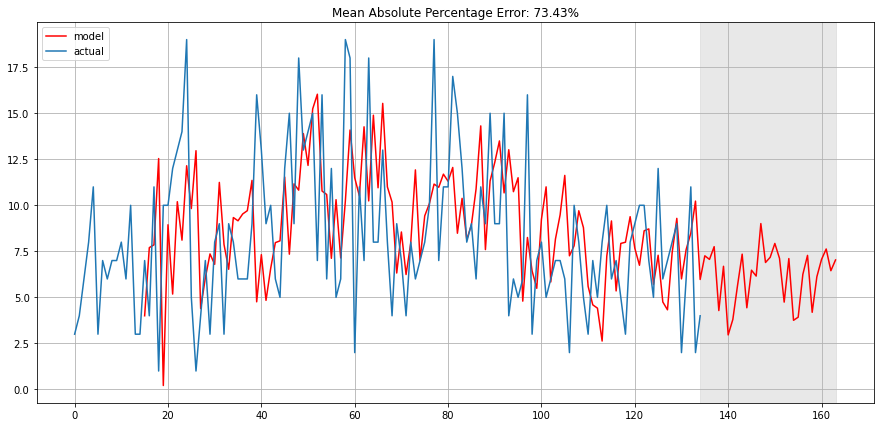

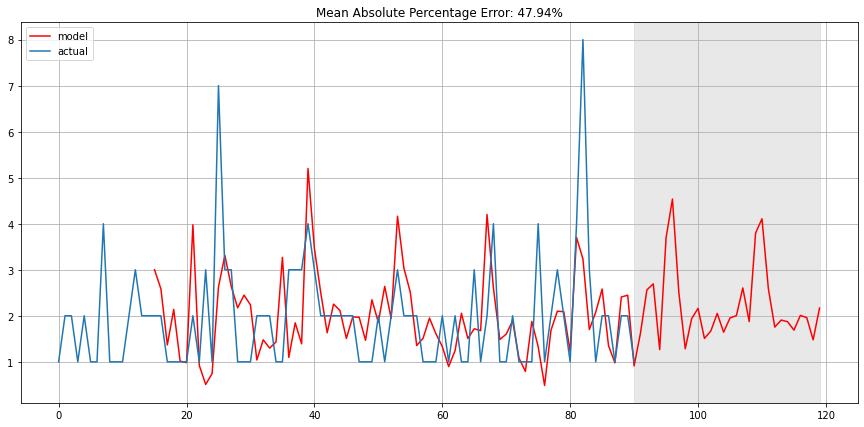

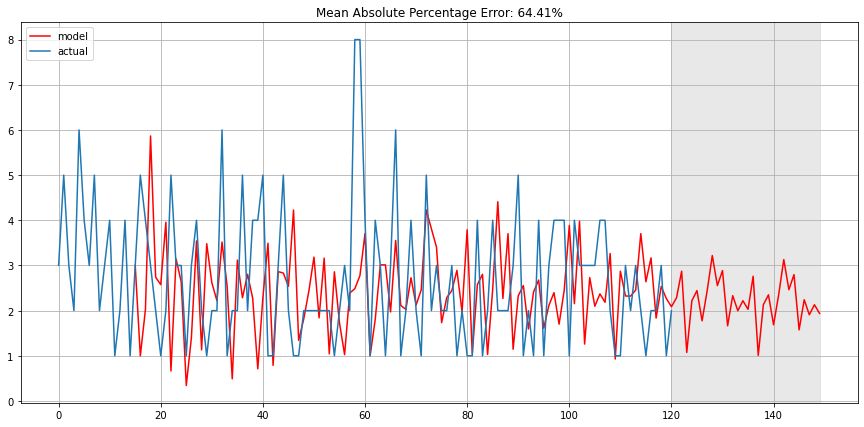

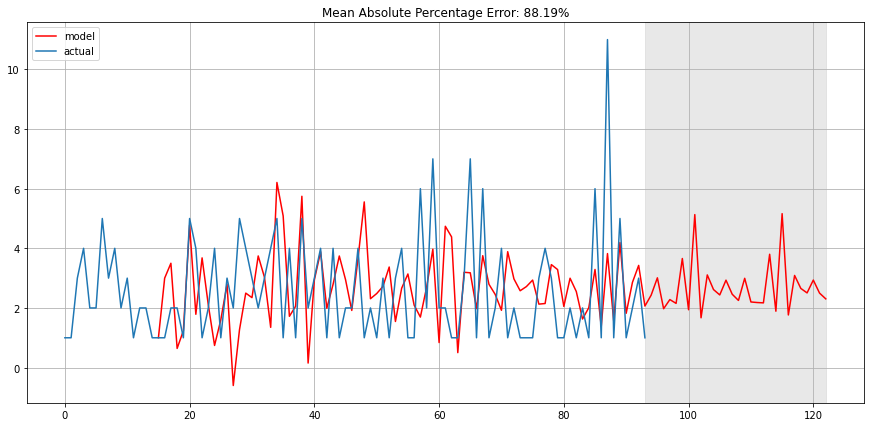

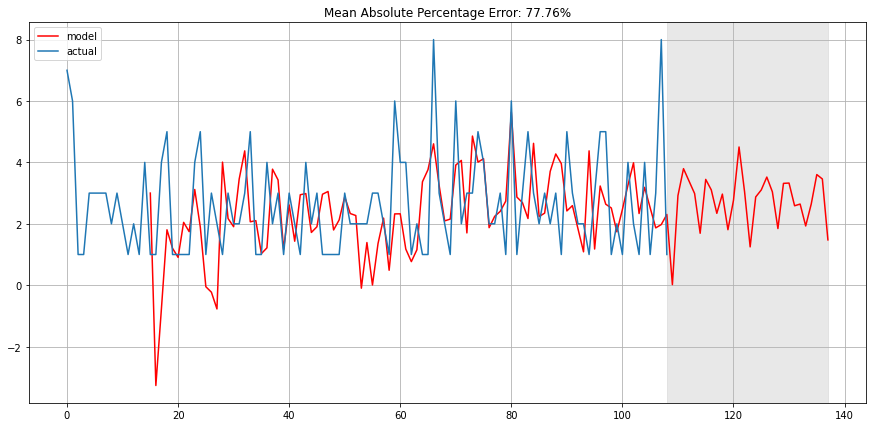

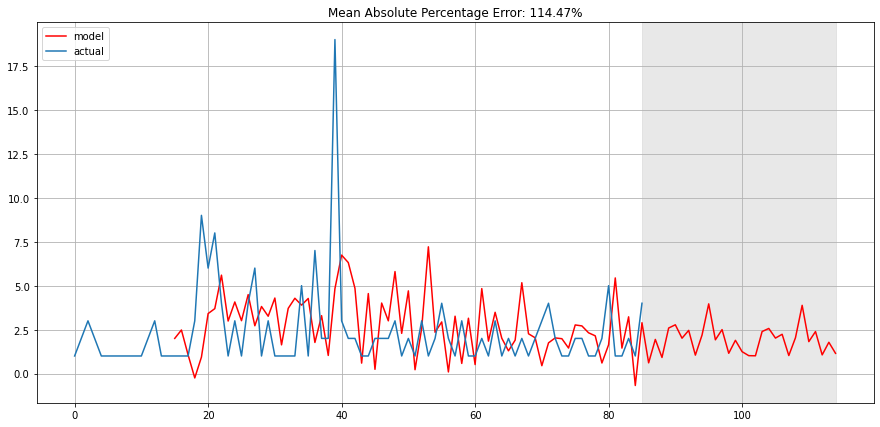

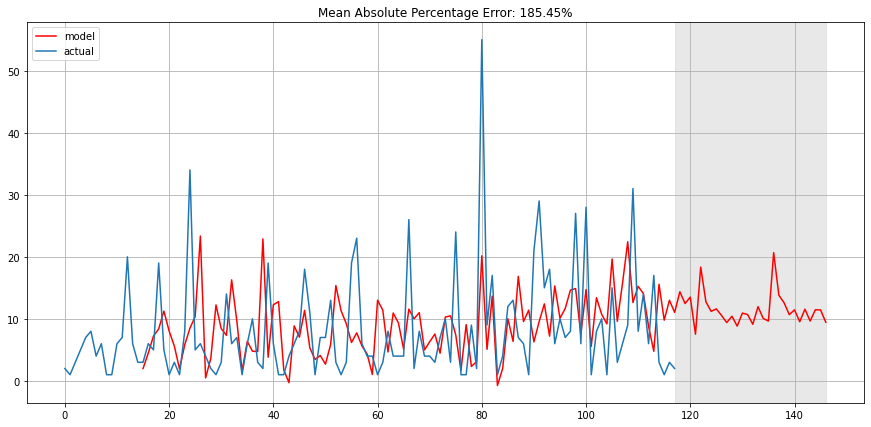

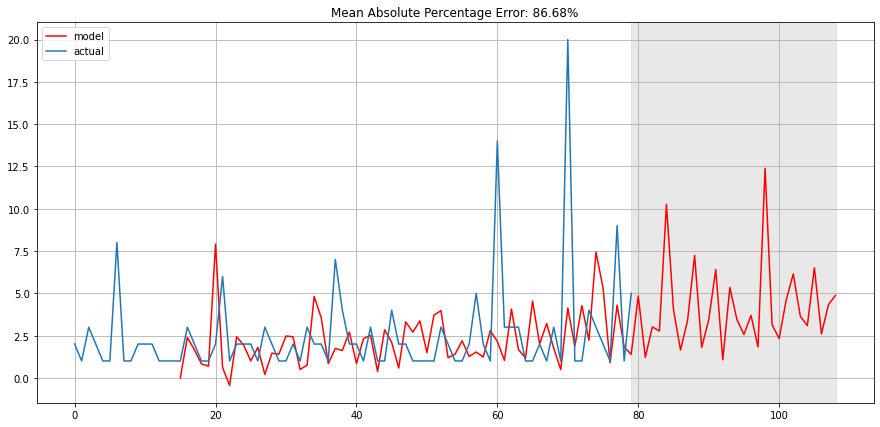

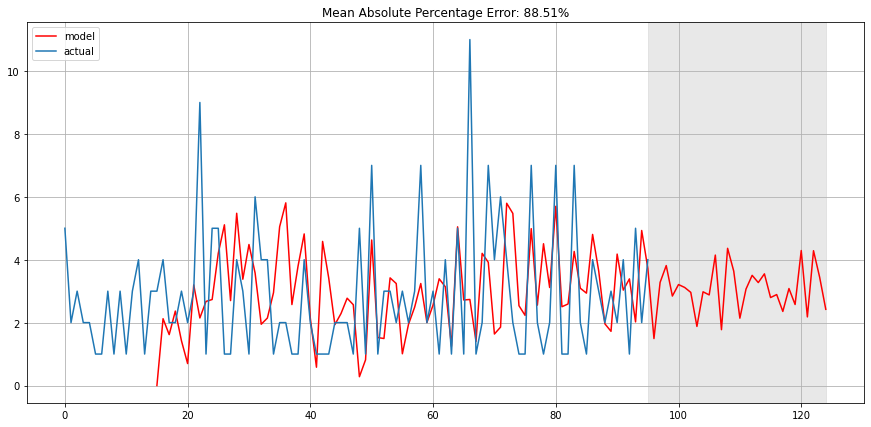

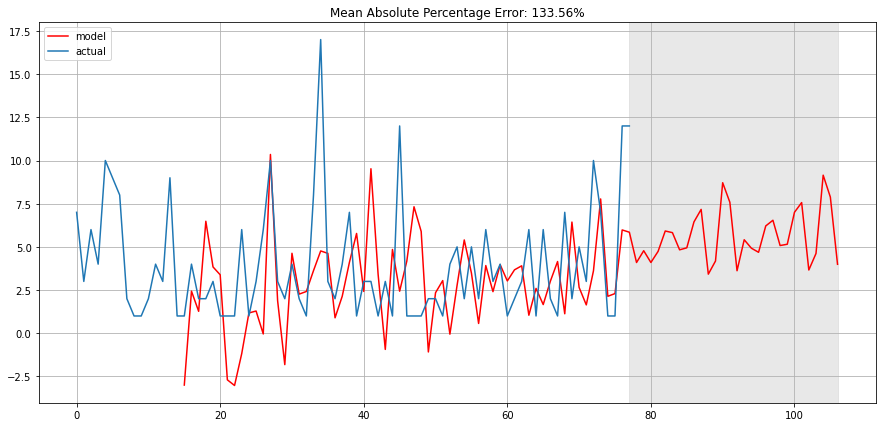

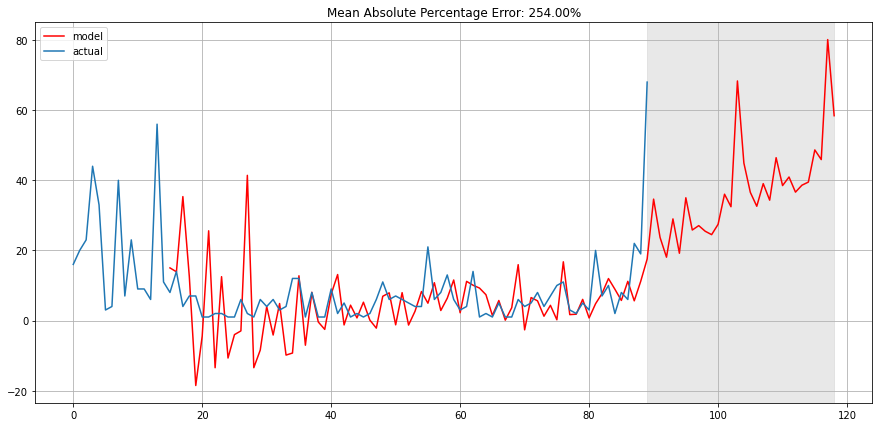

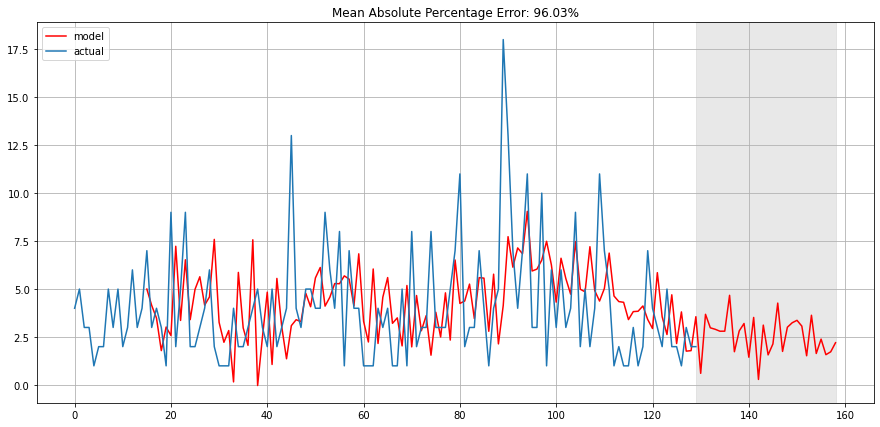

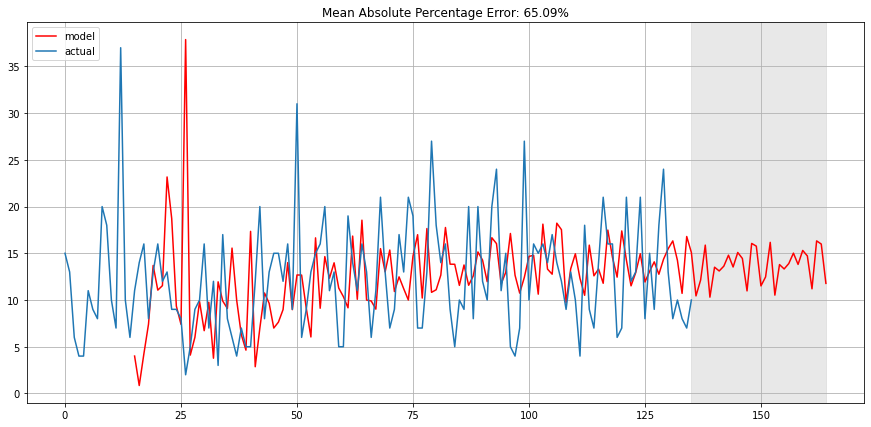

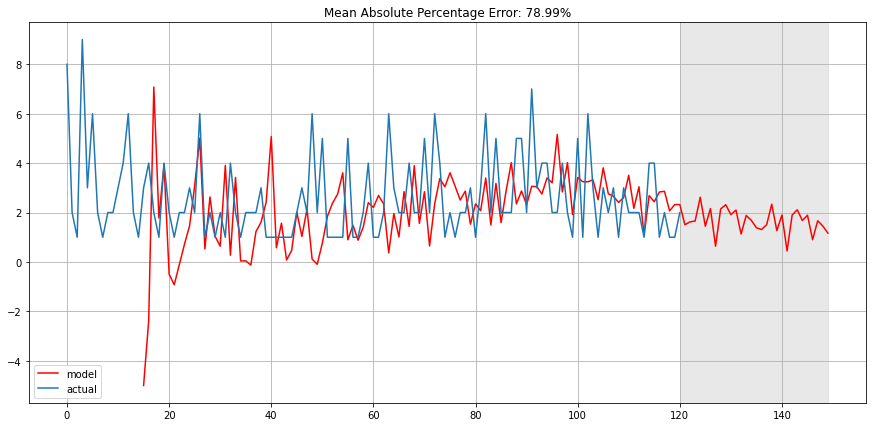

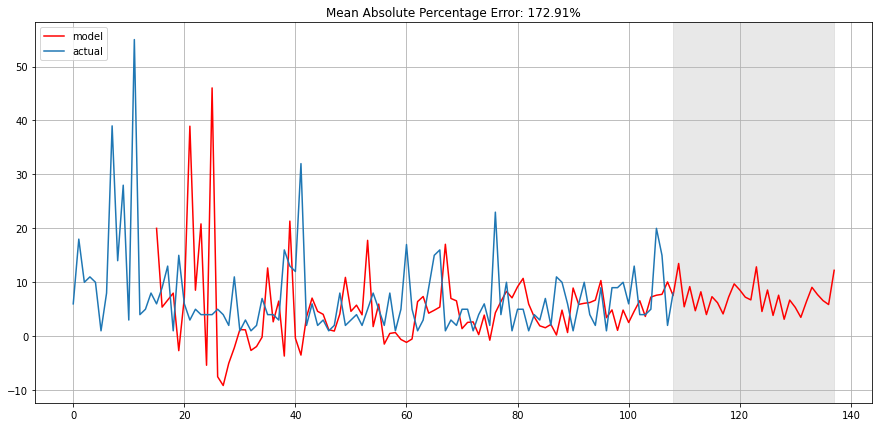

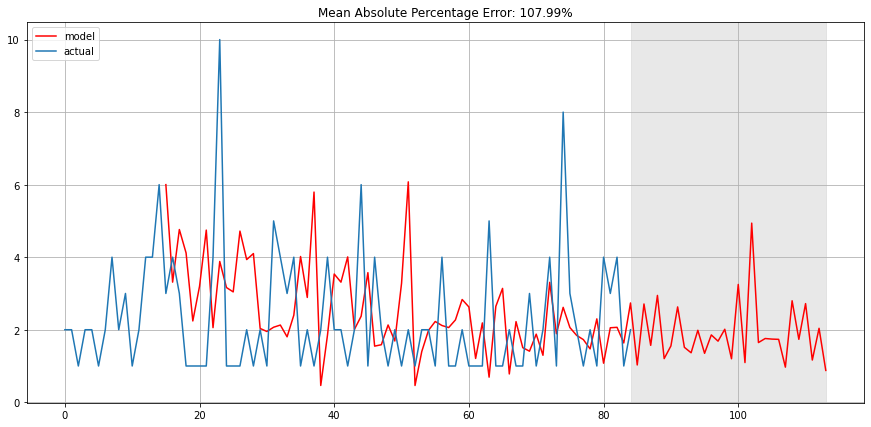

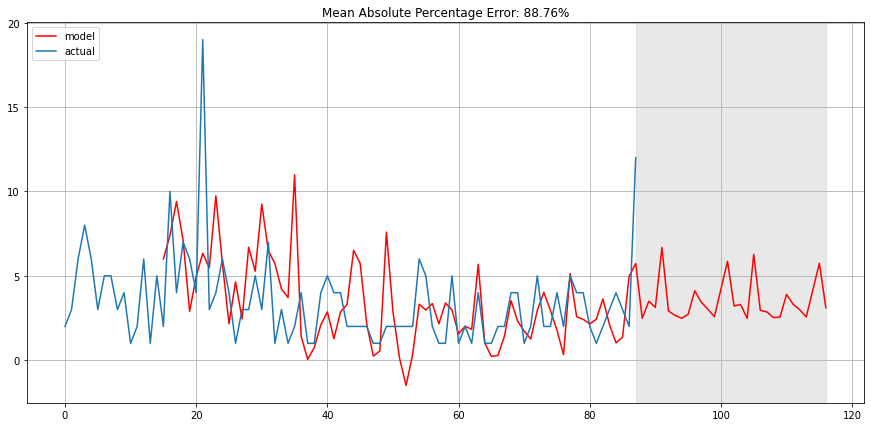

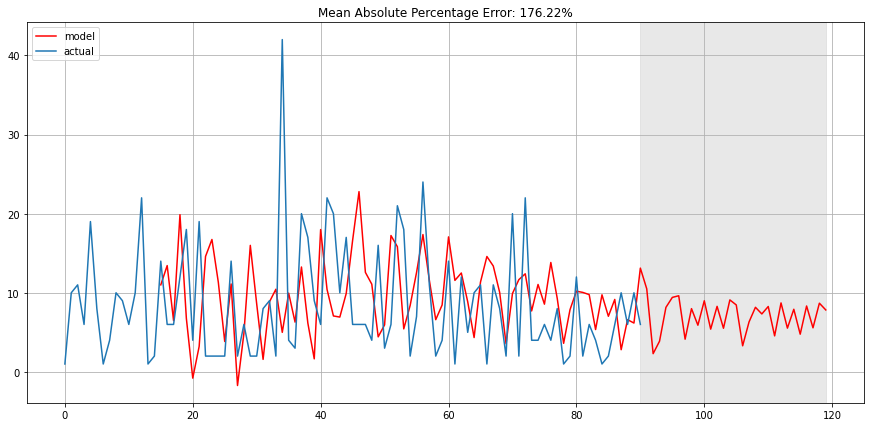

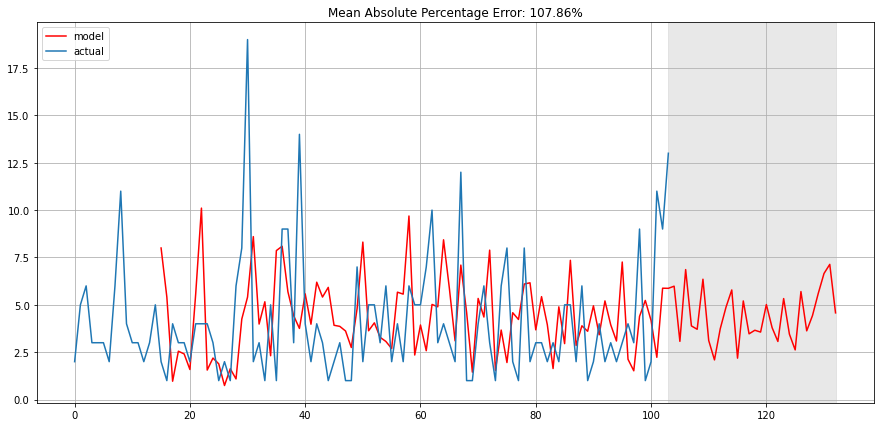

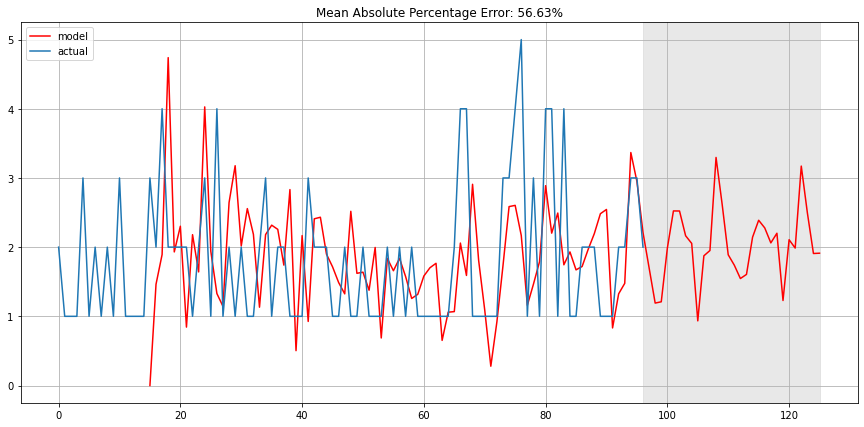

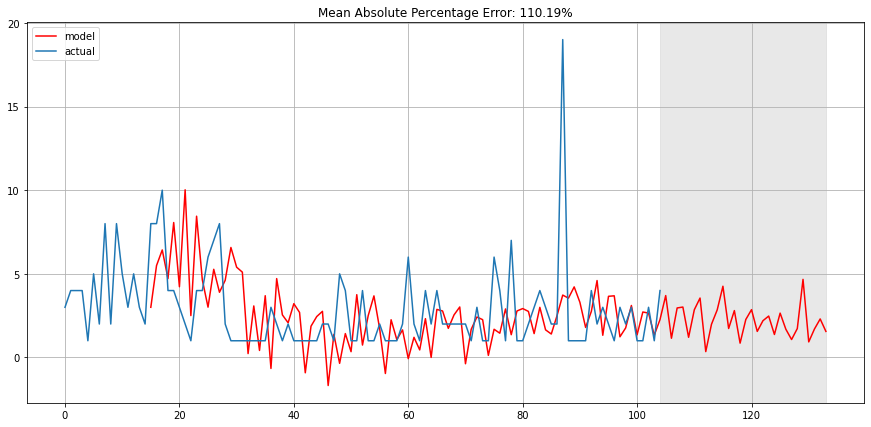

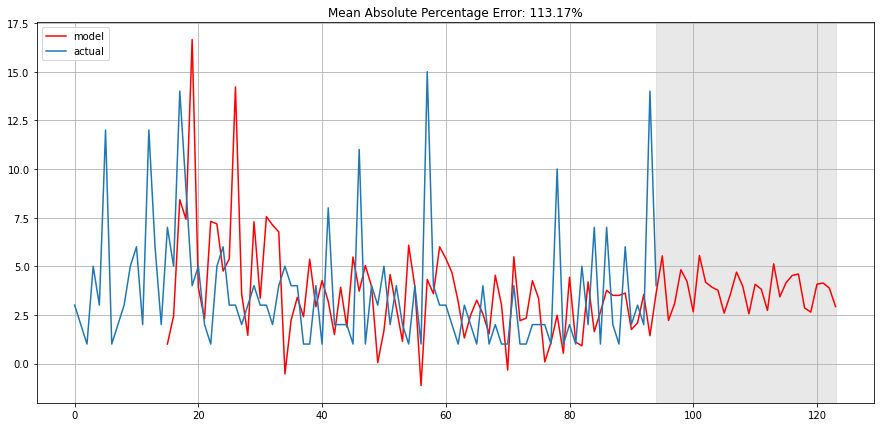

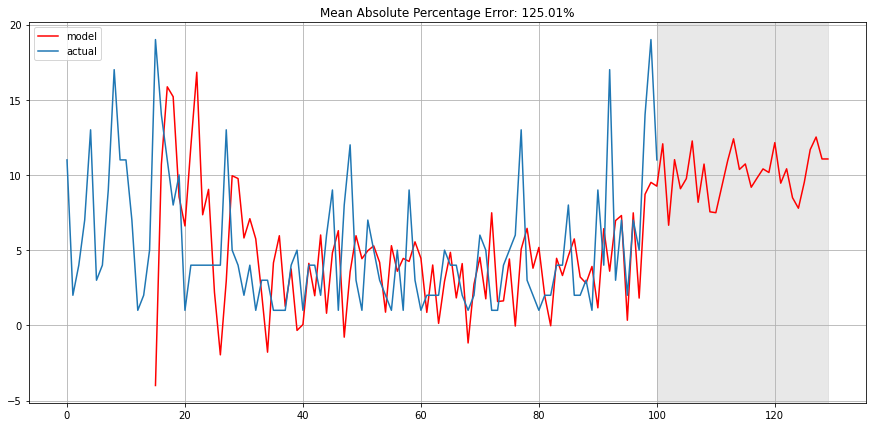

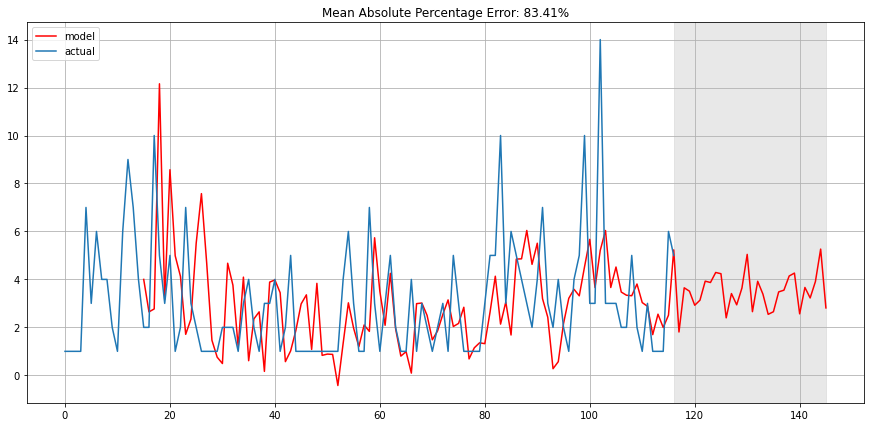

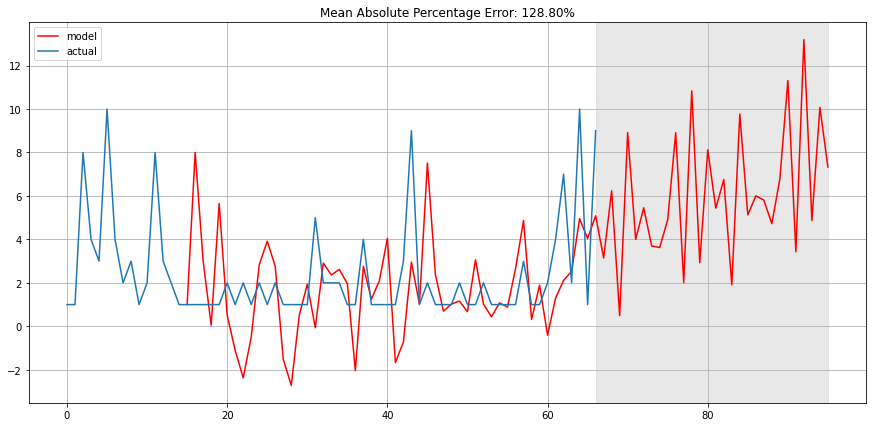

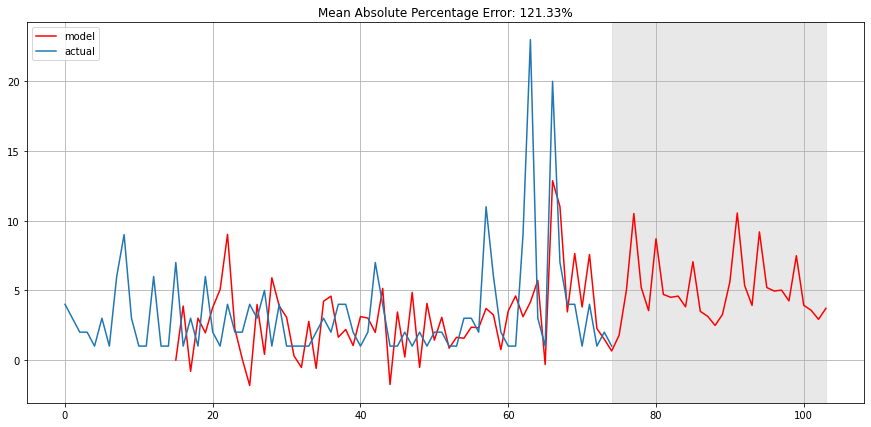

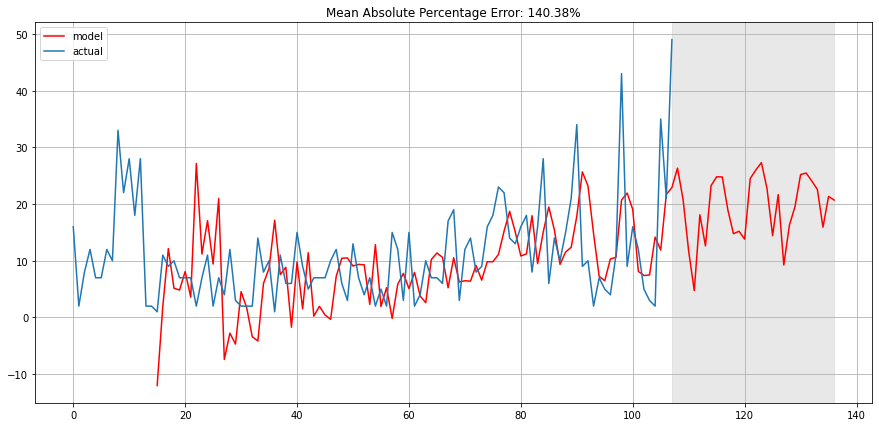

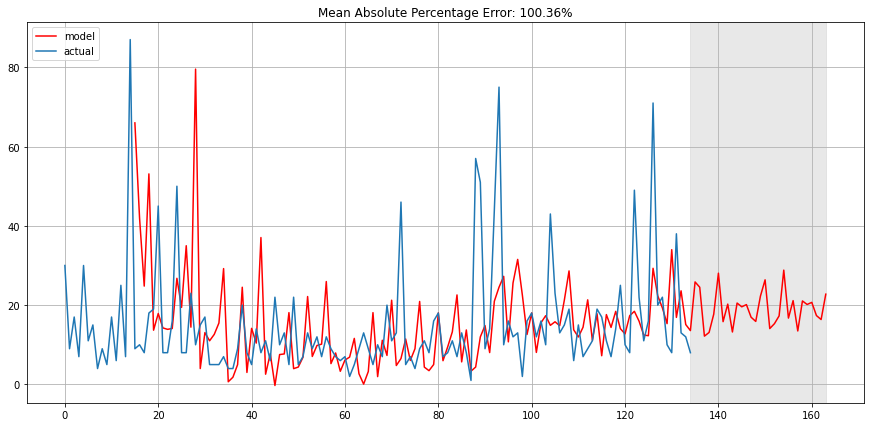

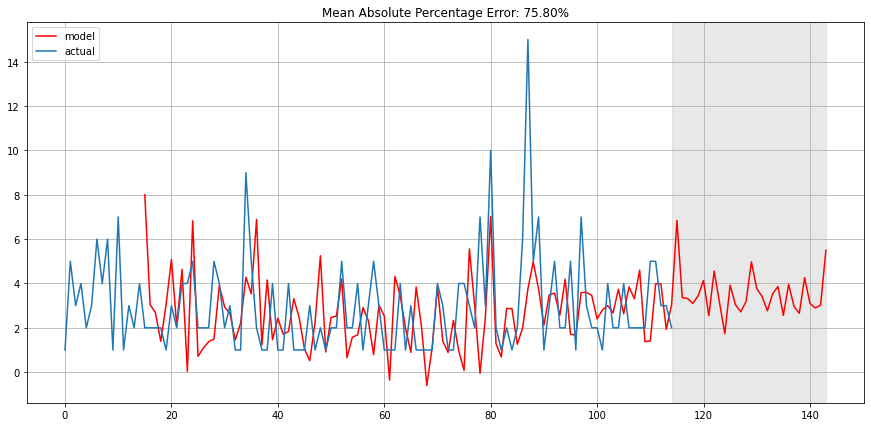

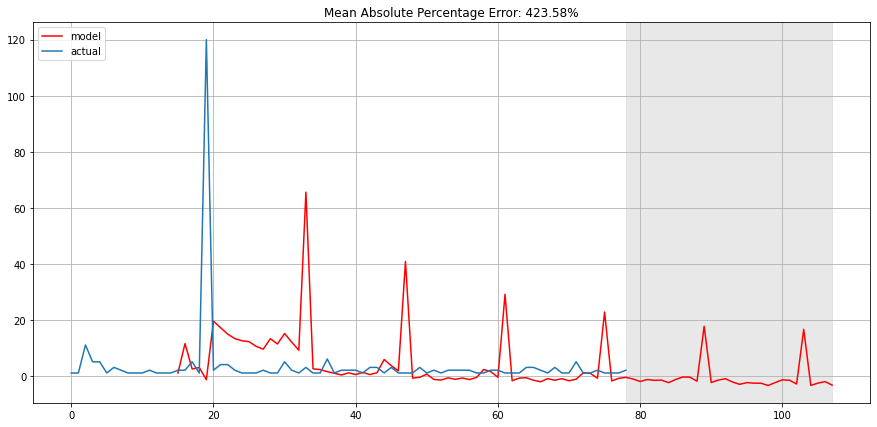

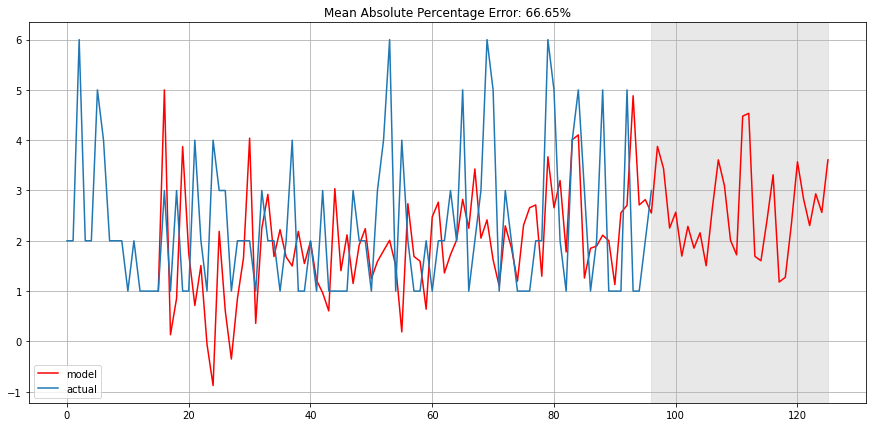

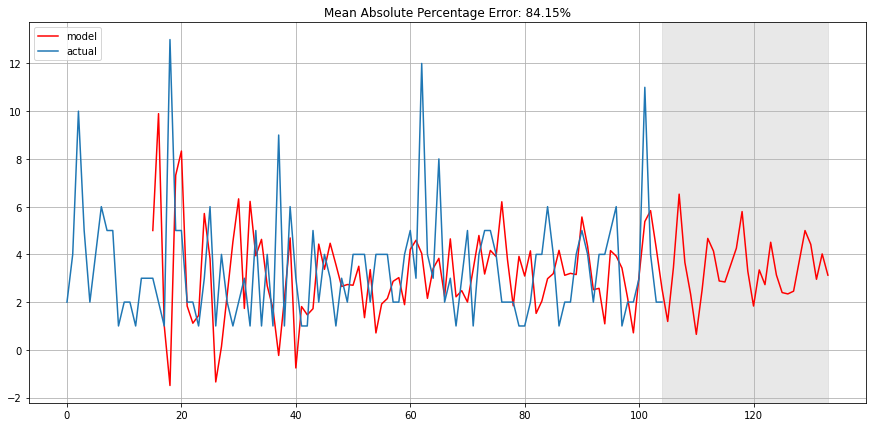

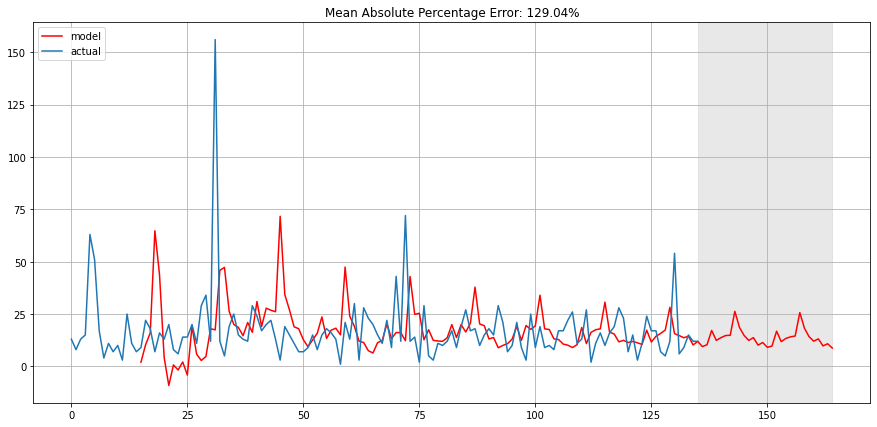

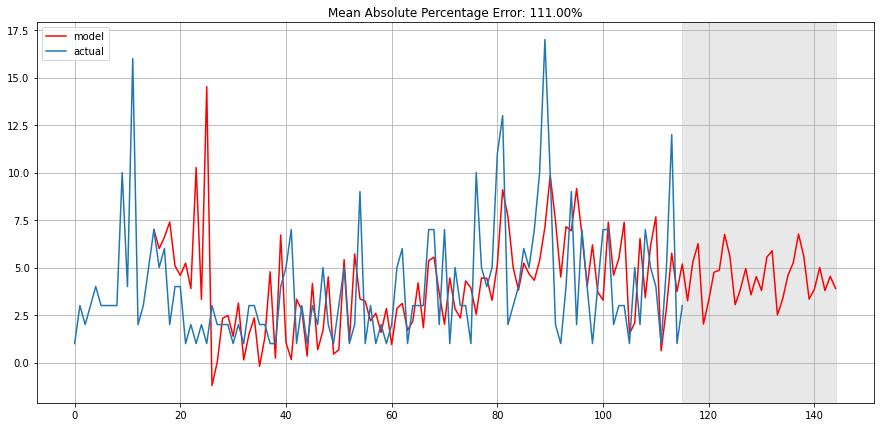

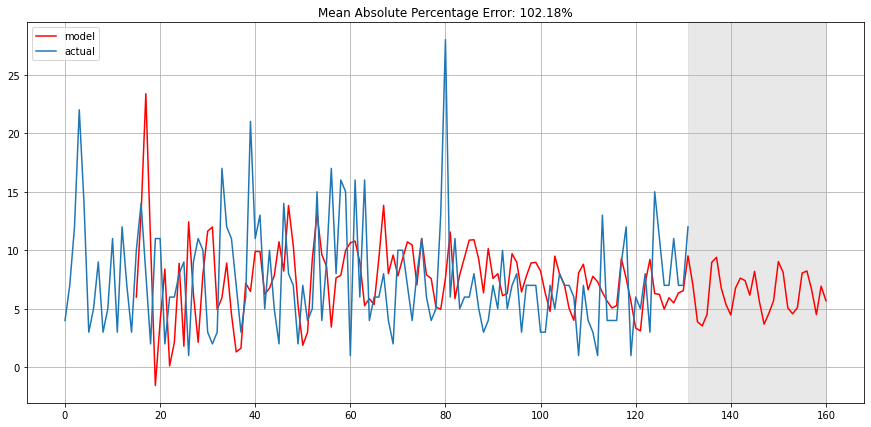

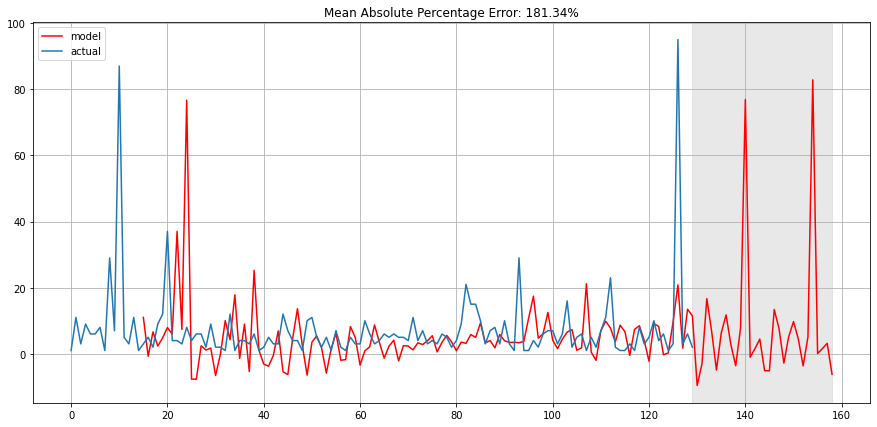

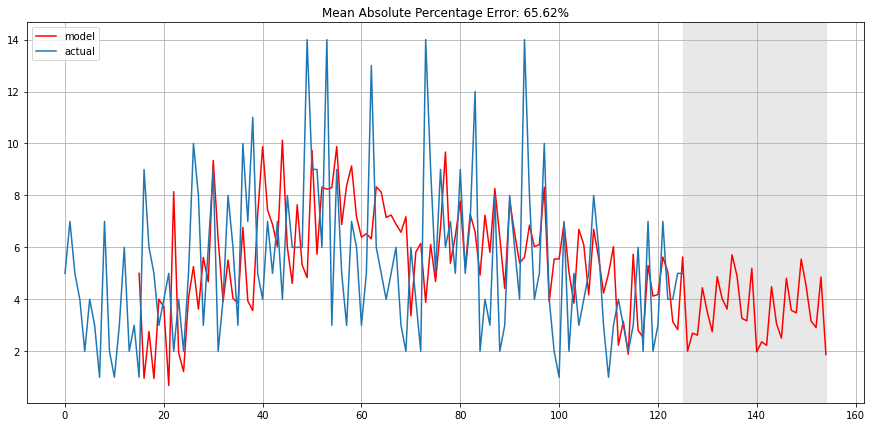

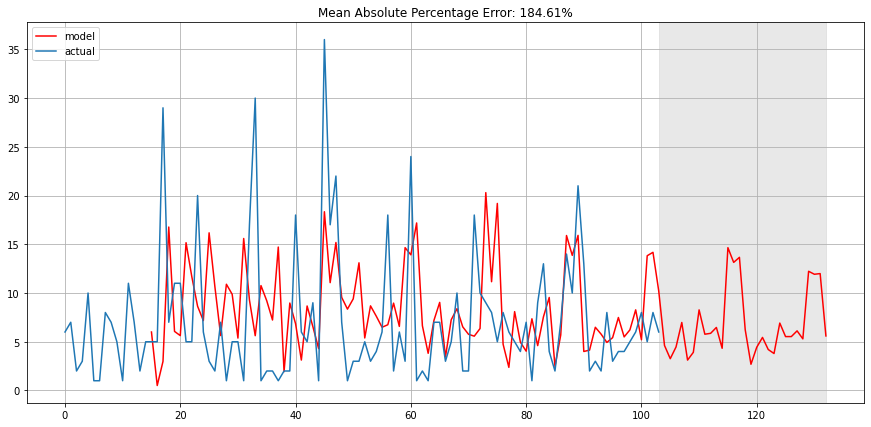

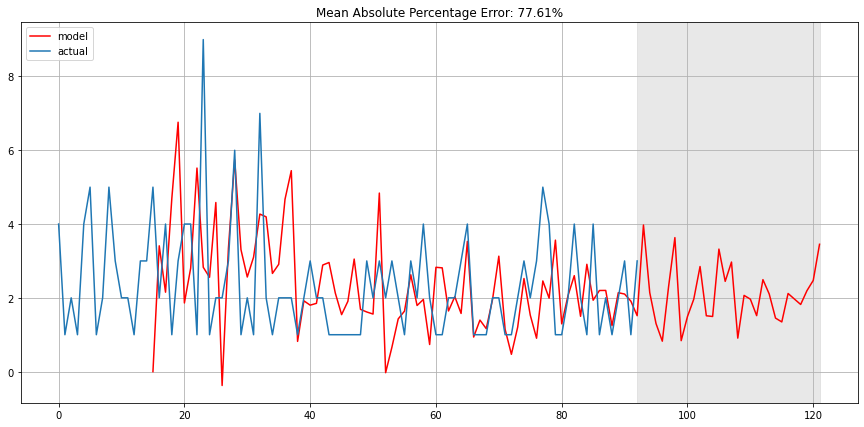

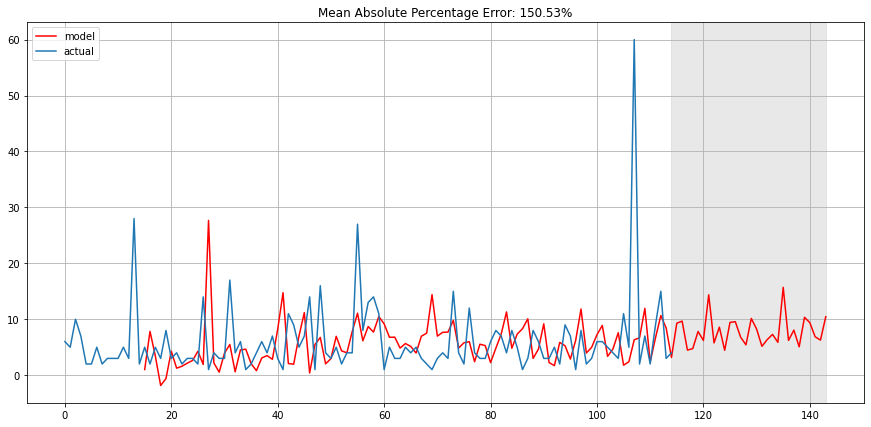

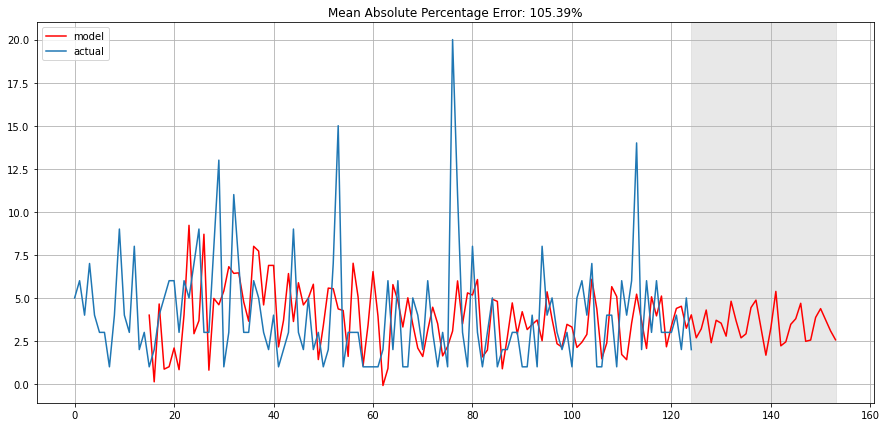

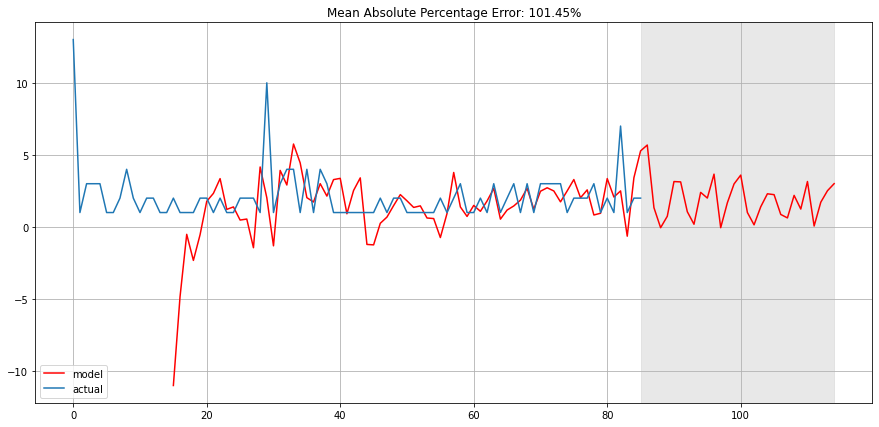

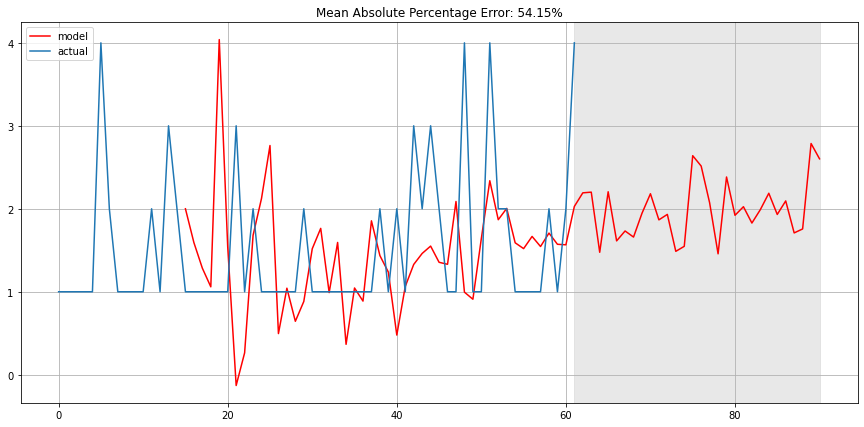

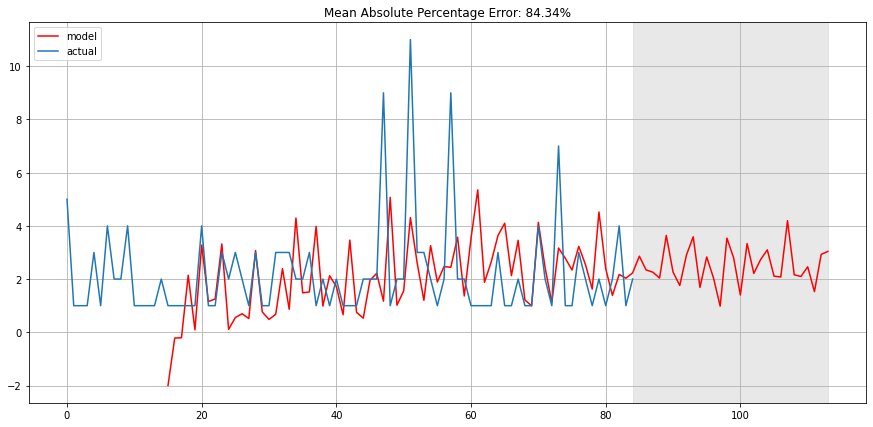

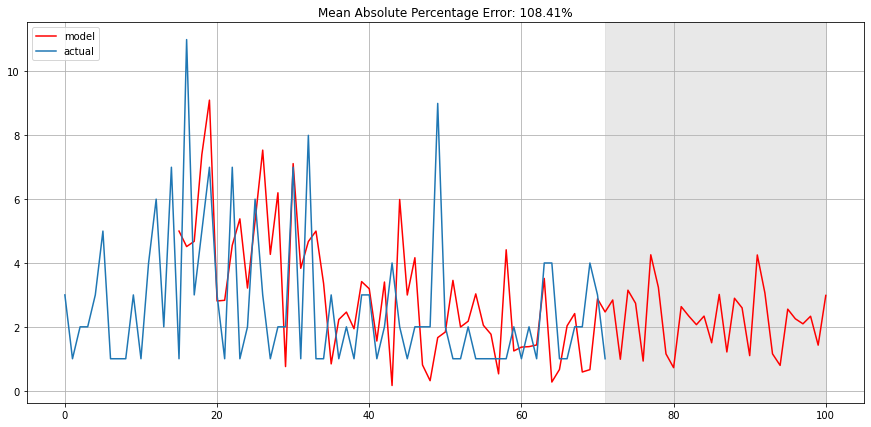

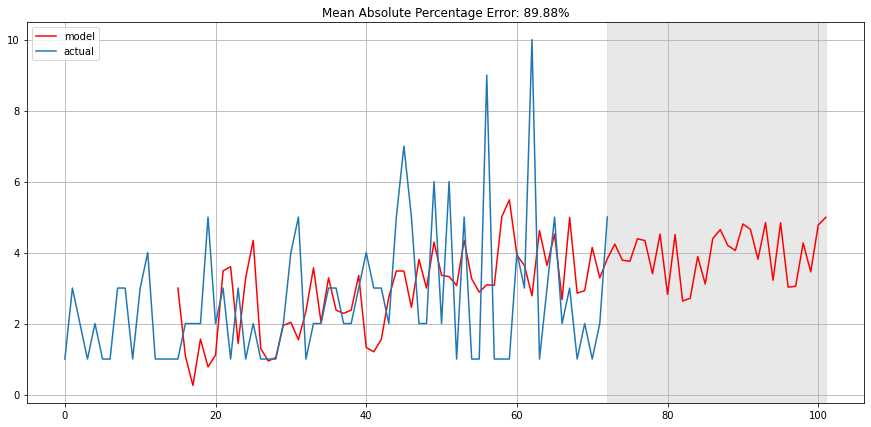

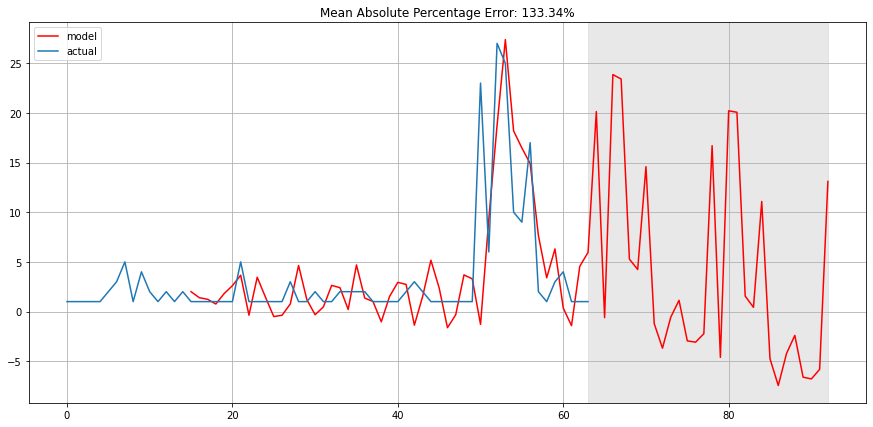

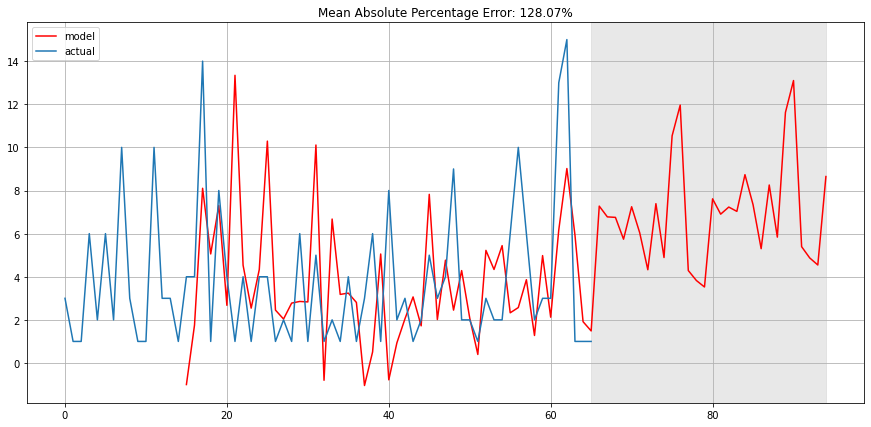

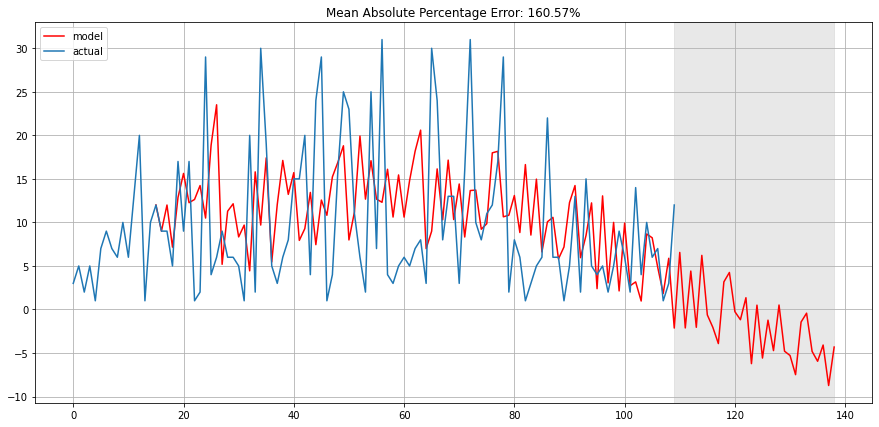

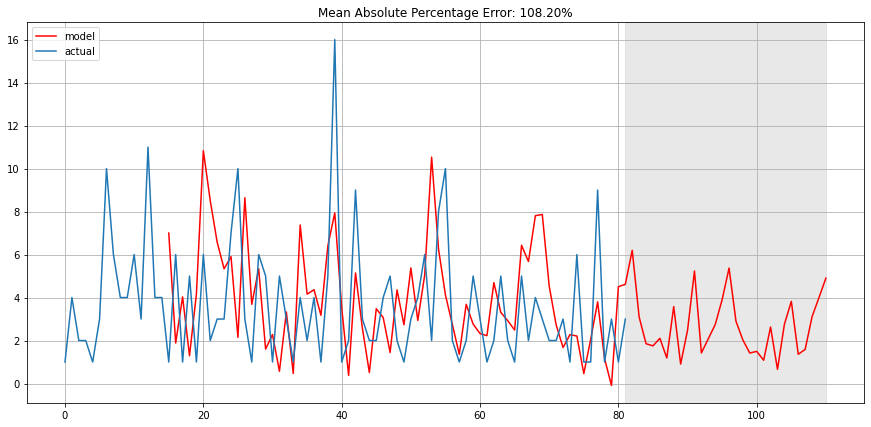

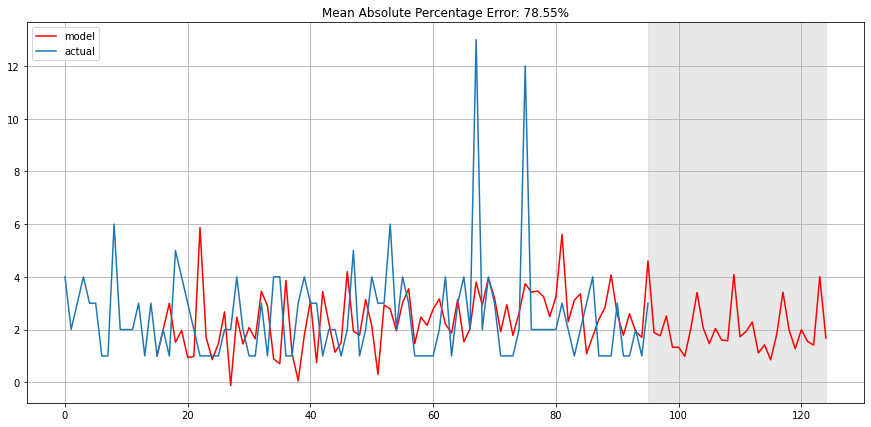

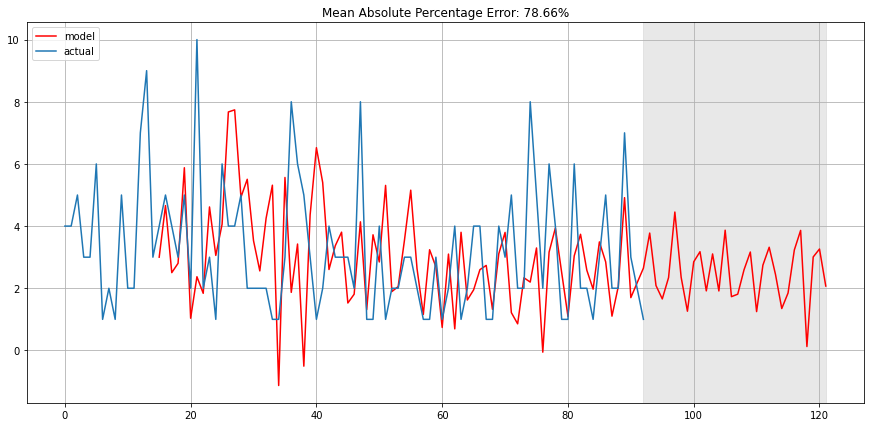

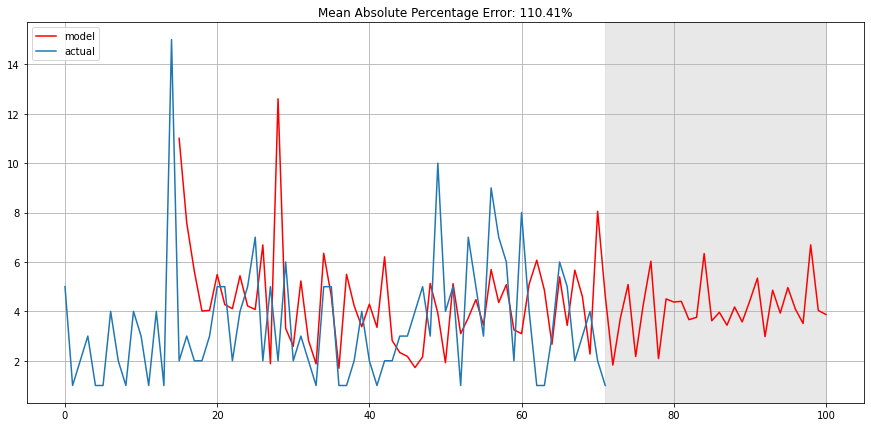

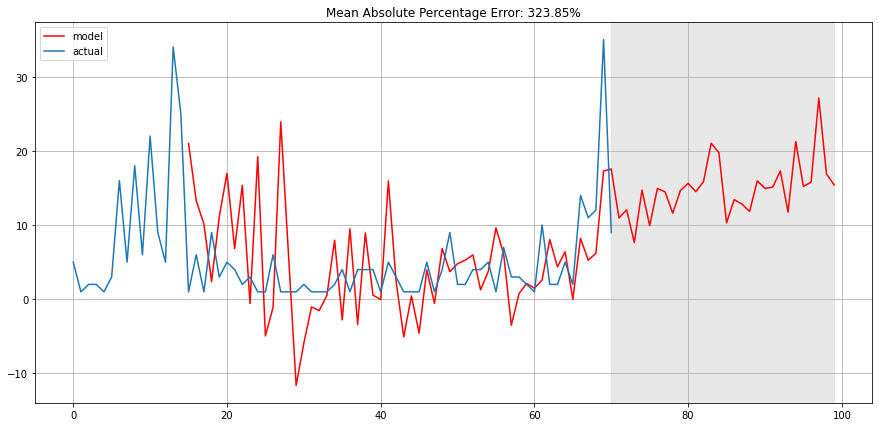

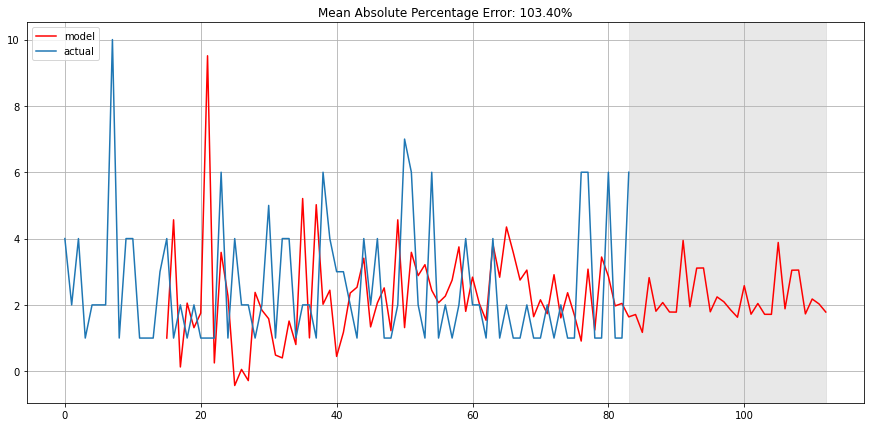

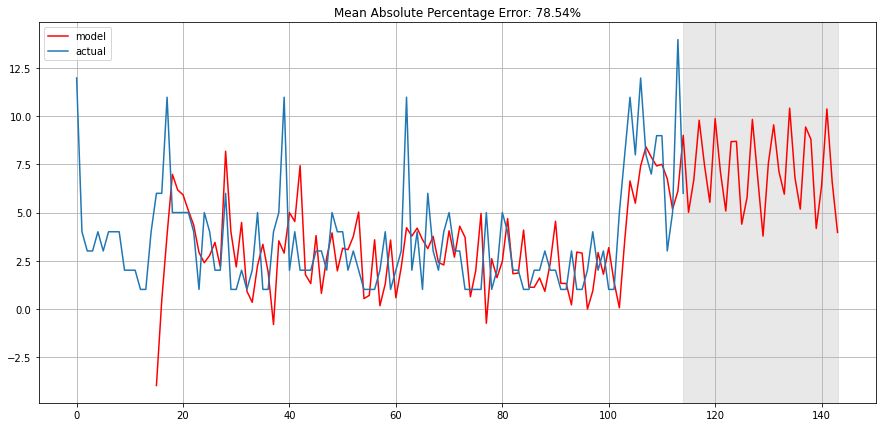

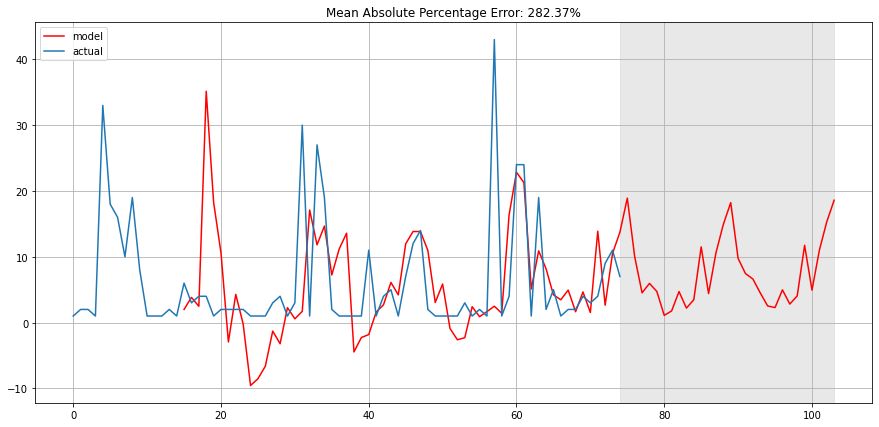

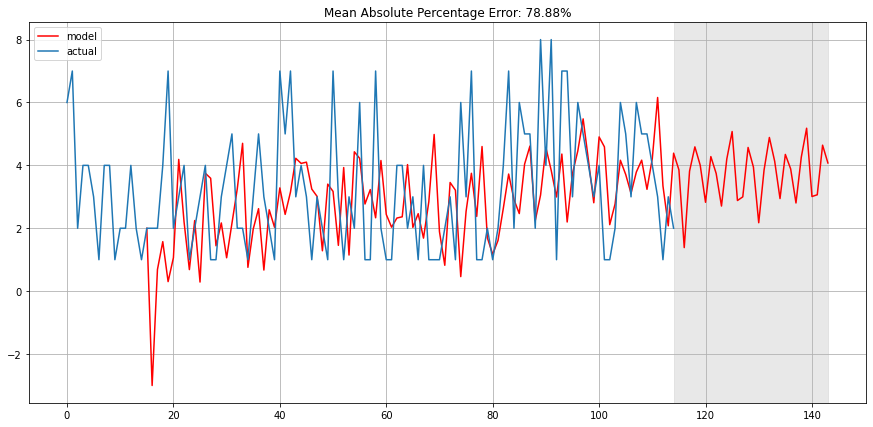

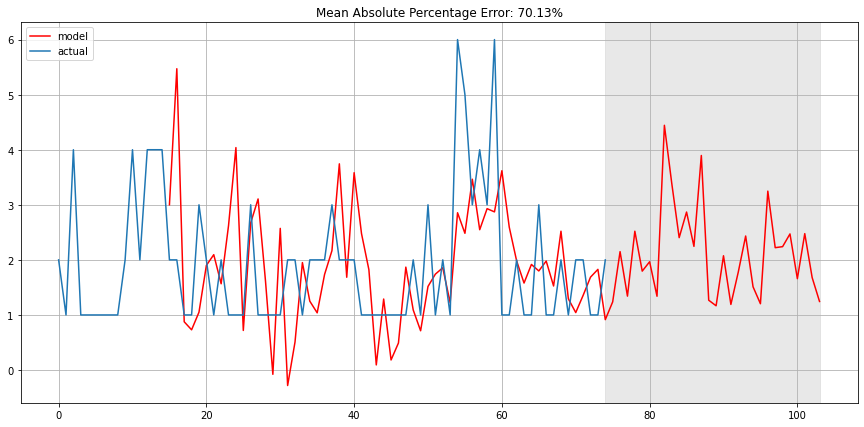

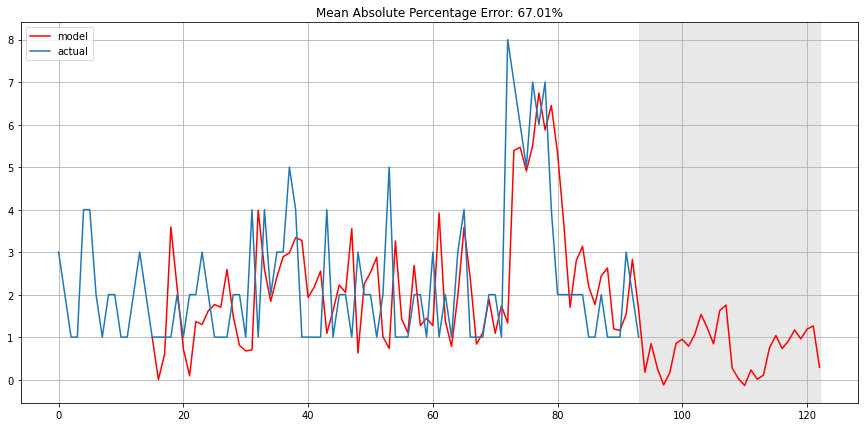

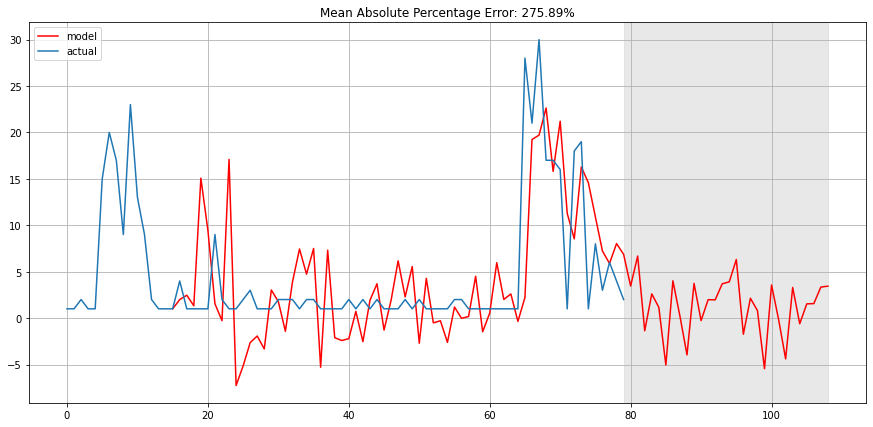

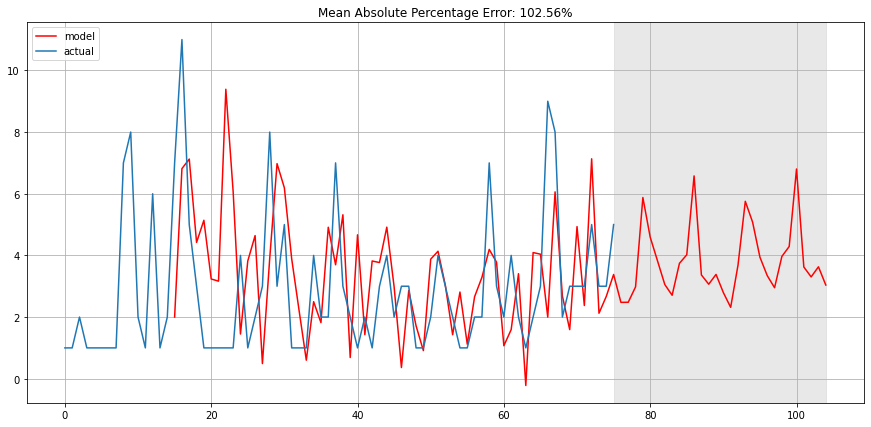

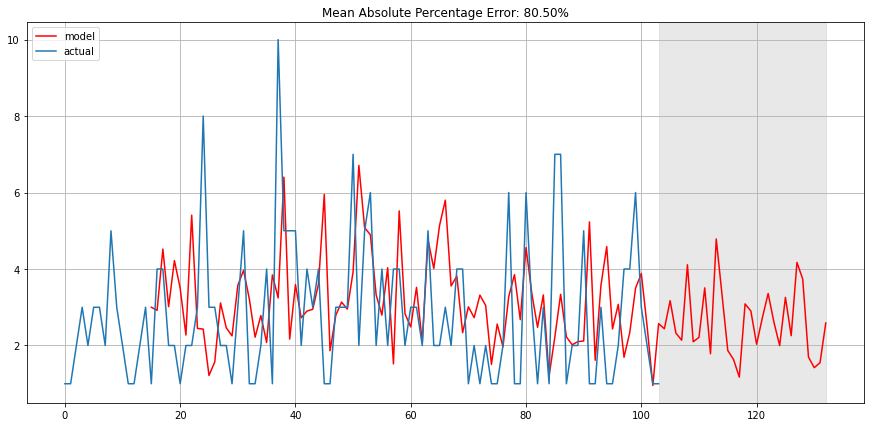

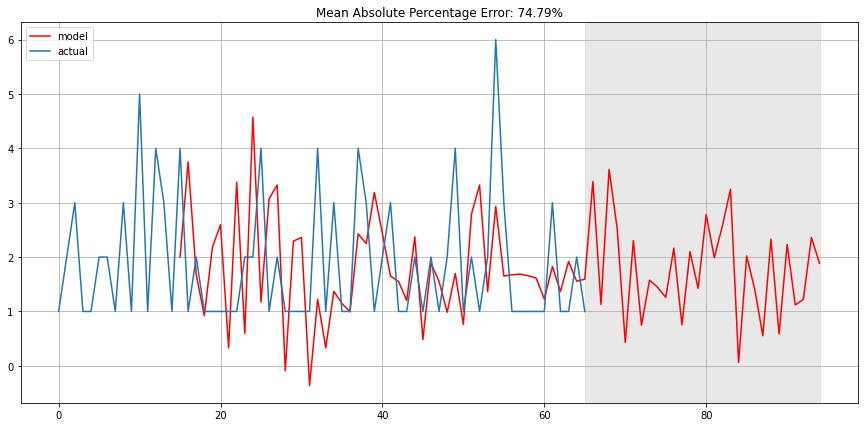

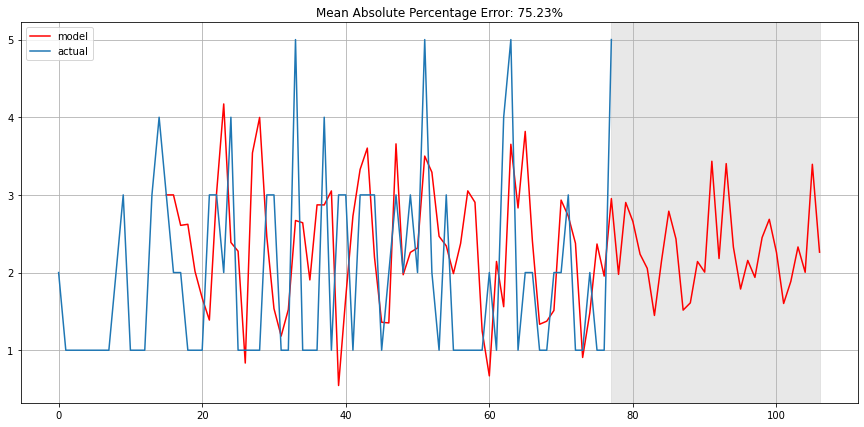

In [21]:
test_list = []
for item in list_test:
    print(item)
    Item_3148_train_dataset = train_dataset.loc[train_dataset['ItemCode'] == item]
    Item_3148_train_dataset.sort_values(by='DateID', inplace=True)
    index = list_test.index(item)
    Item_3148_train_dataset_forTraining = Item_3148_train_dataset[['DateID', 'DailySales']]
    Item_3148_train_dataset_forTraining.head()
    Item_3148_train_dataset_forTraining.index = range(len(Item_3148_train_dataset_forTraining))
    Item_3148_series = Item_3148_train_dataset_forTraining["DailySales"].squeeze()
    print("")
    
    warnings.filterwarnings("ignore") 
    result_table = optimizeSARIMA(Item_3148_series, parameters_list, d, D, s)
    
    p, q, P, Q = result_table.parameters[0]

    best_model=sm.tsa.statespace.SARIMAX(Item_3148_series, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
    print(best_model.summary())
    
    dict_test = plotSARIMA(Item_3148_train_dataset_forTraining, best_model, 28, item, index)
    test_list.append(dict_test)


In [22]:
print(test_list)

[{0: [9925, 20.49129665595937, 22.918093188189783, 23.254489928248727, 24.04995043989307, 74.99095770086305]}, {1: [16936, 54.92680303942635, 57.22918844866008, 54.42018065774094, 57.13132592004543, 145.0535643529766]}, {2: [23200, 190.07090005836505, 183.35527125817887, 220.37196920539066, 209.78643005585792, 110.28426155348987]}, {3: [32245, 40.983672470865756, 43.61152811692195, 43.767780807819456, 43.76519928302504, 136.54212454190778]}, {4: [35449, 32.203098223347375, 34.99110552093688, 37.330459224315696, 39.07955454076911, 105.90180407355847]}, {5: [35530, 21.77396908399246, 32.29966848579262, 22.329564009717327, 33.08062034671827, 120.41961850157638]}, {6: [36898, 78.87858379796879, 68.3396884144311, 72.93279747142648, 66.6743247791268, 80.62690246953179]}, {7: [37510, 13.445195508798854, 11.510963629677132, 13.793931151435562, 11.982785028759062, 88.6380584739589]}, {8: [37861, 199.88476085912487, 241.1707820697975, 207.77016145016282, 262.2830405997928, 114.27959917512732]}, 

In [23]:
dict_test = {"Test Results": test_list}

df = pd.DataFrame(dict_test)

df.to_csv('./SARIMA.csv')

In [ ]:
df = pd.DataFrame.from_records(test_list)
print(df)

In [25]:
list_new = []
for i in range(len(test_list)):
    x=pd.DataFrame.from_dict(test_list[i])
    list_new.append(x)

In [ ]:
print(list_new)

**TBATS**

In [ ]:
!pip install tbats

In [ ]:
from tbats import TBATS, BATS
# Fit the model
estimator = TBATS(seasonal_periods=(14, 30.5))
model_TBA = estimator.fit(Item_3148_series)
# Forecast 365 days ahead
y_forecast = model_TBA.forecast(steps=28)

In [ ]:
# Time series analysis
print(model_TBA.y_hat) # in sample prediction
print("")
print(model_TBA.resid) # in sample residuals
print("")
print(model_TBA.aic)
print("")
# Reading model parameters
print(model_TBA.params.alpha)
print("")
print(model_TBA.params.beta)
print("")
print(model_TBA.params.x0)
print("")
print(model_TBA.params.components.use_box_cox)
print("")
print(model_TBA.params.components.seasonal_harmonics)

In [ ]:
y_forecast = model_TBA.forecast(steps=14)
print(y_forecast)

**Previous Attempts**


In [ ]:
print(type(cat_1_timeseries))

In [ ]:
tsplot(cat_1_timeseries, lags=60)

In [ ]:
diff = cat_1_timeseries - cat_1_timeseries.shift(24)
tsplot(diff[24:], lags=48)

In [ ]:
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

In [ ]:

#%%time
warnings.filterwarnings("ignore") 
result_table = optimizeSARIMA(cat_1_timeseries, parameters_list, d, D, s)

In [ ]:
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(cat_1_timeseries, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

tsplot(best_model.resid[24+1:], lags=48)

In [ ]:
print(cat_1_timeseries.head())

In [ ]:
cat_1_frame = cat_1_timeseries.to_frame()

In [ ]:
print(cat_1_frame.columns)

In [ ]:

plotSARIMA(cat_1_frame, best_model, 30)

In [ ]:
train_path = '../input/weeklyforecasting/weekly_train_data.csv'
train_dataset = pd.read_csv(train_path)
train_dataset = train_dataset.drop_duplicates(keep = 'first')
print(train_dataset)

In [ ]:
Item_3148_train_dataset = train_dataset.loc[train_dataset['ItemCode'] == 3418]
print(Item_3148_train_dataset)

In [ ]:
Item_3148_train_dataset_forTraining = Item_3148_train_dataset[['Week_num', 'WeeklySales']]
Item_3148_train_dataset_forTraining.head()

Item_3148_series = Item_3148_train_dataset_forTraining["WeeklySales"].squeeze()

In [ ]:
tsplot(Item_3148_series, lags=8)

In [ ]:
diff = Item_3148_series - Item_3148_series.shift(5)
tsplot(diff[5:], lags=5)

In [ ]:
warnings.filterwarnings("ignore") 
result_table = optimizeSARIMA(Item_3148_series, parameters_list, d, D, s)

In [ ]:
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(Item_3148_series, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

tsplot(best_model.resid[6+1:], lags=5)

In [ ]:
def fplotSARIMA(series, model, n_steps):
    """Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future    
    """
    
    # adding model values
    data = series.copy()
    data.columns = ['WeeklySales']
    data['sarima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['sarima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.sarima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['WeeklySales'][s+d:], data['sarima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.WeeklySales, label="actual")
    plt.legend()
    plt.grid(True)

In [ ]:
fplotSARIMA(Item_3148_series, best_model, 5)